# Introduction
This notebook is used to explore the dataset we are going to use for the project.

In [3]:
# imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


### Load
We take the season.csv datasets from 2019, 2020, 2021 and 2022 and merge them into one dataset.

In [4]:
base_path = 'data'
file_name = 'season.csv'
type_dict ={
    'LapStartTime': np.float32,
    'LapNumber': np.uint8,
    'LapTime': np.float32,
    'DriverNumber': "category",
    'Team' : "category",
    'Compound': "category",
    'TyreLife': np.uint8,
    'TrackStatus': "category",
    'Stint': np.uint8,
    'DistanceToDriverAhead': np.float32,
    'DriverAhead': "category",
    'PitStatus': "category",
    'IsAccurate': np.bool8,
    'Track': "category",
    'NumberOfPitStops': np.uint8,
    'Position' : np.uint8,
    'GapToLeader' : np.float32,
    'IntervalToPositionAhead' : np.float32,
    'LapsToLeader' : np.uint8,
    'TotalLaps' : np.uint8,
    'AirTemp': np.float32,
    'Humidity': np.float32,
    'Pressure': np.float32,
    'TrackTemp': np.float32,
    'WindDirection': np.float32,
    'WindSpeed': np.float32
    }

In [5]:
df = pd.DataFrame()

for year in range(2019, 2023):
    path = os.path.join(base_path, str(year), file_name)
    df = pd.concat([
        df,
        pd.read_csv(
            path,
            dtype=type_dict,
        )
    ])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87845 entries, 0 to 23512
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   LapStartTime             87845 non-null  float32 
 1   LapNumber                87845 non-null  uint8   
 2   LapTime                  84630 non-null  float32 
 3   DriverNumber             87845 non-null  object  
 4   Team                     87845 non-null  object  
 5   Compound                 87845 non-null  object  
 6   TyreLife                 87845 non-null  uint8   
 7   TrackStatus              87845 non-null  object  
 8   Stint                    87845 non-null  uint8   
 9   DistanceToDriverAhead    81424 non-null  float32 
 10  DriverAhead              81424 non-null  object  
 11  PitStatus                87845 non-null  category
 12  IsAccurate               87845 non-null  bool    
 13  NumberOfPitStops         87845 non-null  uint8   
 14  Positi

### Colonne TrackStatus

La colonne TrackStatus contient un ensemble d'entier concaténés. Chaque entier représente un statut de la piste qui à eu lieu au cours du tour :
* 1 : Drapeau vert (piste libre)
* 2 : Drapau jaune (piste partiellement bloquée)
* 4 : Voiture de sécurité
* 5 : Drapeau rouge (interruption de la session)
* 6 : Voiture de sécurité virtuelle
* 7 : Fin de la voiture de sécurité

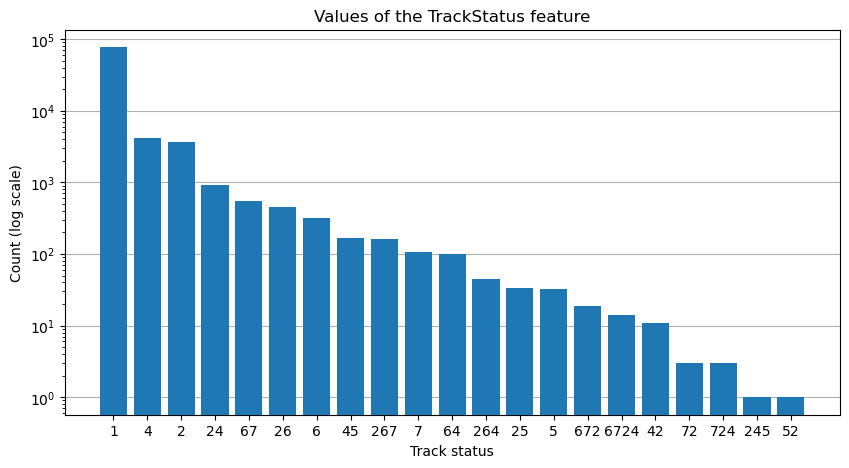

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x=df['TrackStatus'].value_counts().index, height=df['TrackStatus'].value_counts().values, zorder=3)
ax.set_yscale('log')
ax.set_title('Values of the TrackStatus feature')
ax.set_xlabel('Track status')
ax.set_ylabel('Count (log scale)')
ax.grid(axis='y')
plt.savefig(format='svg', fname='figures/track_status.svg')
plt.show()

Pour utiliser cette feature je vais la transformer en 6 features binaires. Chaque feature représente un statut de la piste. Si le statut est présent dans la colonne TrackStatus alors la feature vaut 1 sinon elle vaut 0.

In [8]:
def trackStatus_to_binary(trackStatus):
    status = pd.Series(
        np.zeros(6, dtype=np.bool8),
        index=['Green', 'Yellow', 'SC', 'Red', 'VSC', 'SC_ending']
    )
    if "1" in trackStatus:
        status['Green'] = True
    if "2" in trackStatus:
        status['Yellow'] = True
    if "4" in trackStatus:
        status['SC'] = True
    if "5" in trackStatus:
        status['Red'] = True
    if "6" in trackStatus:
        status['VSC'] = True
    if "7" in trackStatus:
        status['SC_ending'] = True
    return status

trackStatuses = df['TrackStatus'].apply(trackStatus_to_binary)

df = pd.concat([df, trackStatuses], axis=1).reset_index(drop=True)

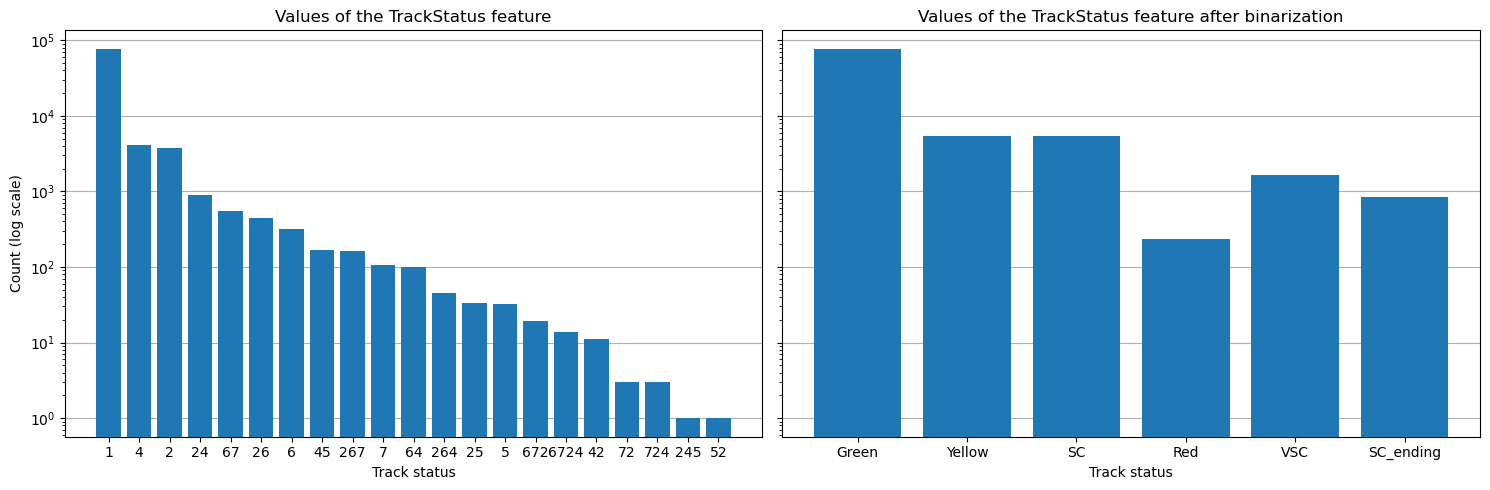

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)

axes[0].bar(x=df['TrackStatus'].value_counts().index, height=df['TrackStatus'].value_counts().values, zorder=3)
axes[0].set_ylabel('Count (log scale)')
axes[0].set_yscale('log')
axes[0].set_title('Values of the TrackStatus feature')
axes[0].set_xlabel('Track status')
axes[0].grid(axis='y')
axes[1].bar(x=df[['Green', 'Yellow', 'SC', 'Red', 'VSC', 'SC_ending']].sum().index, height=df[['Green', 'Yellow', 'SC', 'Red', 'VSC', 'SC_ending']].sum().values, zorder=3)
axes[1].set_title('Values of the TrackStatus feature after binarization')
axes[1].set_xlabel('Track status')

axes[1].grid(axis='y')
fig.tight_layout()
plt.savefig(format='svg', fname='figures/track_status_binarized.svg')
plt.show()

In [10]:
df.drop('TrackStatus', axis=1, inplace=True)

### Valeurs manquantes
* On remarque que il y a **20** tours ou il n'y a pas de données météo, étant donnée que dans un premier temps on ne va pas utiliser les données météo, on peut les garder.
* Plus problématique, il y a **6'455** tours sans données `DriverAhead` et `DistanceToDriverAhead`. Je suspecte que ça soit les tours de sortie de débuts de course et simplement les tours du pilote leader de la course.
* Il y a également **3'261** tours sans données `LapTime`, je suspecte que ça soit aussi les tours de sortie de débuts de course.

In [11]:
df_cleaning = df[df['DriverAhead'].isna()]
df_cleaning.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6421 entries, 0 to 87829
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   LapStartTime             6421 non-null   float32 
 1   LapNumber                6421 non-null   uint8   
 2   LapTime                  4546 non-null   float32 
 3   DriverNumber             6421 non-null   object  
 4   Team                     6421 non-null   object  
 5   Compound                 6421 non-null   object  
 6   TyreLife                 6421 non-null   uint8   
 7   Stint                    6421 non-null   uint8   
 8   DistanceToDriverAhead    0 non-null      float32 
 9   DriverAhead              0 non-null      object  
 10  PitStatus                6421 non-null   category
 11  IsAccurate               6421 non-null   bool    
 12  NumberOfPitStops         6421 non-null   uint8   
 13  Position                 6421 non-null   uint8   
 14  GapToLe

Premièrement, je remarque qu'il y a uniquement **1'909** lignes avec des valeurs manquantes pour `LapTime`, se qui veut dire que **1'352** autres tours n'ont pas de laptime.

In [12]:
pd.Series(df_cleaning['LapNumber']).value_counts().sort_index()

1     1584
2      115
3      132
4       79
5       77
      ... 
83       1
84       1
85       1
86       1
87       1
Name: LapNumber, Length: 86, dtype: int64

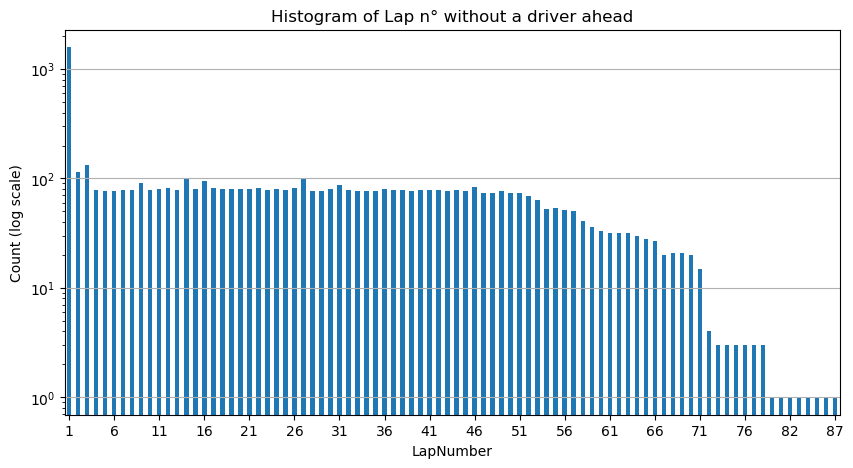

In [13]:
ax = pd.Series(df_cleaning['LapNumber']).value_counts().sort_index().plot(
    kind='bar', 
    figsize=(10, 5), 
    title='Histogram of Lap n° without a driver ahead', 
    xlabel='LapNumber', 
    ylabel='Count (log scale)',
    rot=0,
    logy=True
)

ax.set_xticks(np.arange(
        start=df_cleaning['LapNumber'].min() - 1, 
        stop=df_cleaning['LapNumber'].max(),
        step=5
    ))

ax.grid(axis='y')

plt.savefig(format='svg', fname='figures/lap_number_without_driver_ahead.svg')

Comme attendu, la plupart des lignes avec des valeurs manquantes sont des lignes de début de course avant le 2ème tour. Le reste de la distribution est assez uniforme avec une légère diminution de la fréquence après 55 tours, ce qui est logique car la majorité des courses durent entre 50 et 60 tours.

Je vais donc supprimer les lignes de début de course, c'est à dire les lignes avec `LapNumber` < 2.

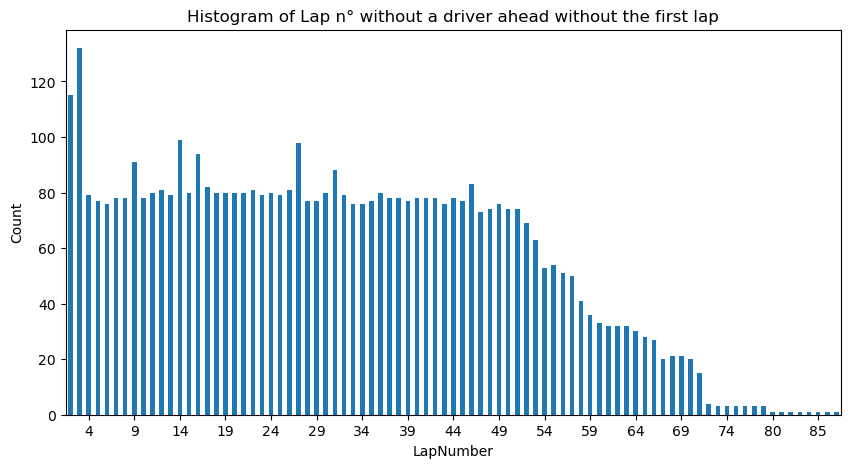

In [14]:
df_cleaning = df_cleaning[df_cleaning['LapNumber'] > 1]

ax = pd.Series(df_cleaning['LapNumber']).value_counts().sort_index().plot(
    kind='bar', 
    figsize=(10, 5), 
    title='Histogram of Lap n° without a driver ahead without the first lap', 
    xlabel='LapNumber', 
    ylabel='Count',
    rot=0,
)

ax.set_xticks(np.arange(
        start=df_cleaning['LapNumber'].min(),
        stop=df_cleaning['LapNumber'].max(),
        step=5
    )
)


In [15]:
df = df[df['LapNumber'] > 1]

---

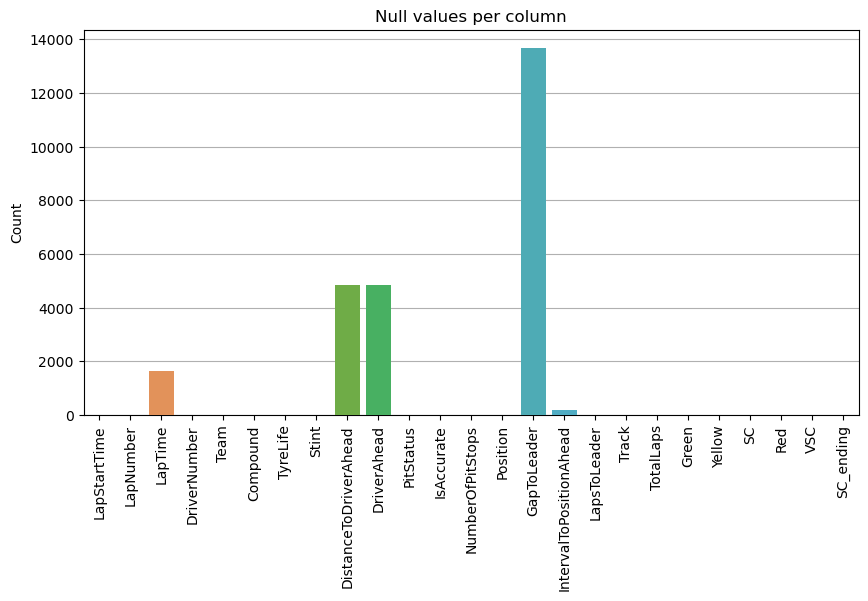

In [16]:
# Bar chart of the null values per column using seaborn
plt.figure(figsize=(10, 5))
sns.barplot(x=df.drop(['AirTemp', 'Humidity', 'Pressure', 'TrackTemp', 'WindDirection', 'WindSpeed', 'Rainfall'], axis=1).isna().sum().index, y=df.drop(['AirTemp', 'Humidity', 'Pressure', 'TrackTemp', 'WindDirection', 'WindSpeed', 'Rainfall'], axis=1).isna().sum().values, zorder=3)
plt.title('Null values per column')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.savefig(format='svg', fname='figures/null_values_per_column.svg')
plt.show()


On remarque que maintenant que quasiment toutes les lignes avec des valeurs manquantes pour `LapTime` ont été supprimées. 

Les tours sans données `DriverAhead` et `DistanceToDriverAhead` sont maintenant uniquement les tours du pilote leader de la course se qui est logique.

Les valeurs null de `GapToLeader` sont celle des pilotes qui ont au moins un tour de retard sur le leader de la course. Similairement, les valeurs manquantes de `IntervalToPositionAhead` sont celles des pilotes qui ont au moins un tour de retard sur la voiture devant eux (se qui est rare et explique le nombre plus faible d'occurence)

*Il semble qu'au passage, on ait supprimé les lignes avec les valeurs de météo manquantes*

Il reste cependant, **1645** tours sans données pour la colonne 'LapTime`.

In [17]:
df['HasLapTime'] = ~df['LapTime'].isna()

<AxesSubplot: title={'center': 'LapTime null values per TrackStatus'}, xlabel='HasLapTime', ylabel='Count'>

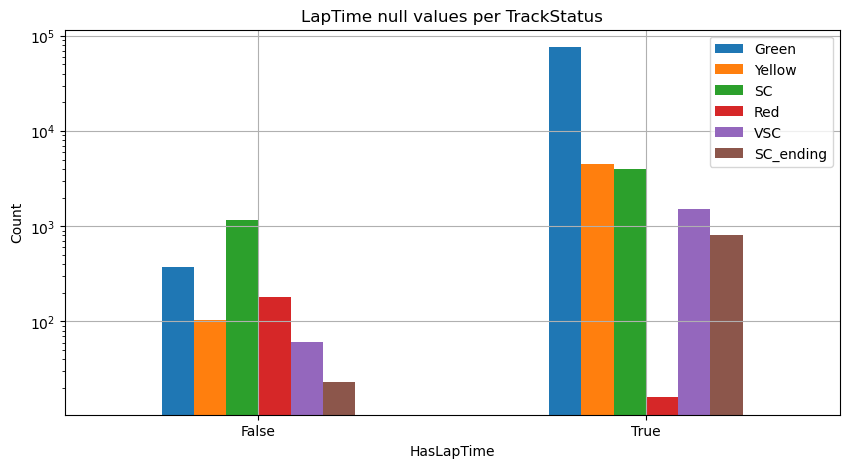

In [18]:
df[['HasLapTime', 'Green', 'Yellow', 'SC', 'Red', 'VSC', 'SC_ending']].groupby('HasLapTime').sum().plot(kind='bar', figsize=(10, 5), title='LapTime null values per TrackStatus', xlabel='HasLapTime', ylabel='Count', rot=0, grid=True, logy=True)

C:\Users\NelsonWork\AppData\Local\Temp\ipykernel_9180\3827230562.py:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corrwith(df['HasLapTime']).plot(kind='bar', figsize=(20, 5), title='Correlation with HasLapTime', xlabel='Feature', ylabel='Correlation', grid=True)


<AxesSubplot: title={'center': 'Correlation with HasLapTime'}, xlabel='Feature', ylabel='Correlation'>

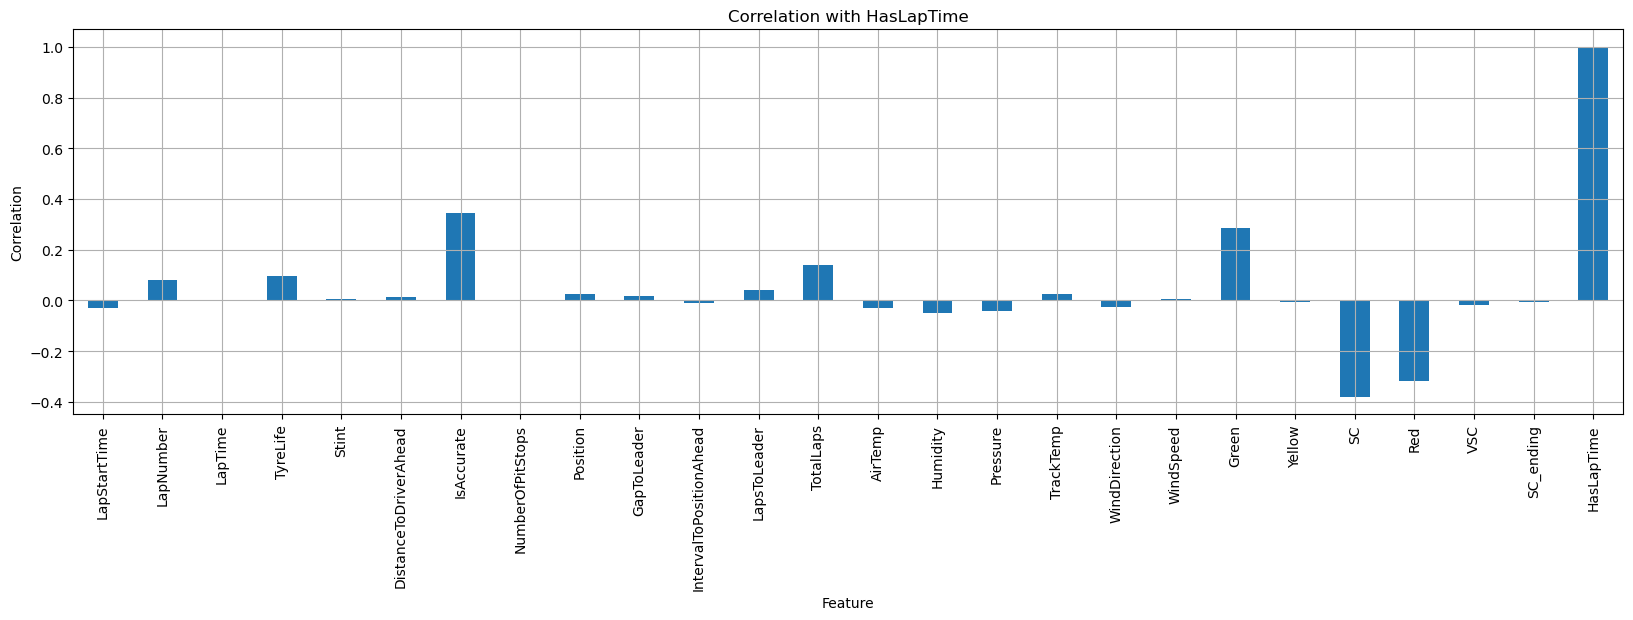

In [19]:
df.corrwith(df['HasLapTime']).plot(kind='bar', figsize=(20, 5), title='Correlation with HasLapTime', xlabel='Feature', ylabel='Correlation', grid=True)

---
Il semble difficile de définir une règle pour remplir les valeurs manquantes. Je vais donc simplement supprimer les lignes avec des valeurs manquantes.

In [20]:
df = df.drop(axis=0, index=df[df['HasLapTime'] == False].index)
df = df.drop('HasLapTime', axis=1)

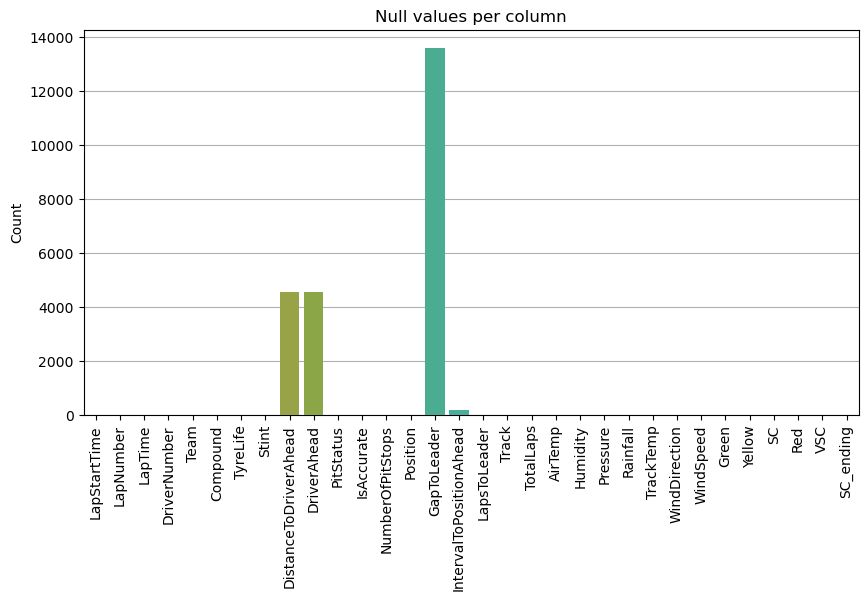

In [21]:
# Bar chart of the null values per column using seaborn
plt.figure(figsize=(10, 5))
sns.barplot(x=df.isna().sum().index, y=df.isna().sum().values, zorder=3)
plt.title('Null values per column')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.savefig(format='svg', fname='figures/null_values_per_column_after_cleaning.svg')
plt.show()

In [22]:
gapToLeaderGrouppedByLapsToLeader = df[df['GapToLeader'].isna()][['GapToLeader', 'LapsToLeader', 'LapNumber']].groupby('LapsToLeader').count()
gapToLeaderGrouppedByLapsToLeader.loc[0, 'GapToLeader'] = 0
gapToLeaderGrouppedByLapsToLeader.loc[0, 'LapNumber'] = 0
gapToLeaderGrouppedByLapsToLeader.sort_index(inplace=True)

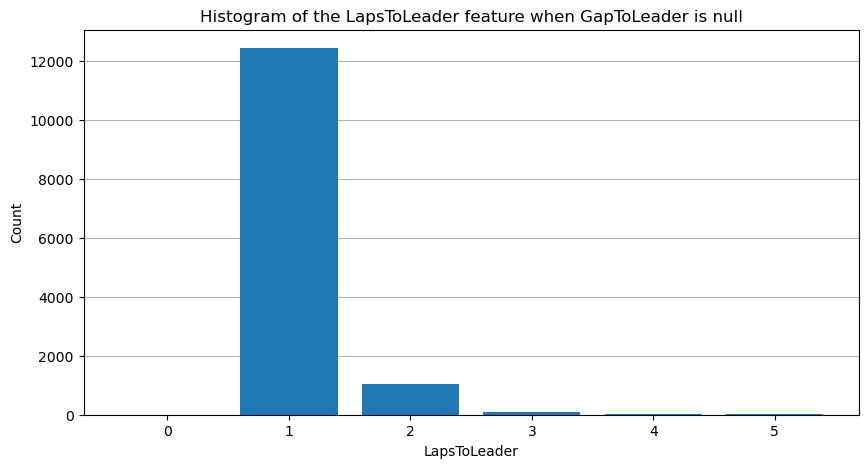

In [23]:
plt.figure(figsize=(10, 5))
plt.bar(x=gapToLeaderGrouppedByLapsToLeader.index, height=gapToLeaderGrouppedByLapsToLeader['LapNumber'], zorder=3)
plt.title('Histogram of the LapsToLeader feature when GapToLeader is null')
plt.xlabel('LapsToLeader')
plt.ylabel('Count')
plt.grid(axis='y')
plt.savefig(format='svg', fname='figures/gap_to_leader_when_laps_to_leader_is_null.svg')
plt.show()

In [24]:
# boolean
df['Green'] = df['Green'].astype('bool')
df['Yellow'] = df['Yellow'].astype('bool')
df['SC'] = df['SC'].astype('bool')
df['Red'] = df['Red'].astype('bool')
df['VSC'] = df['VSC'].astype('bool')
df['SC_ending'] = df['SC_ending'].astype('bool')
df['IsAccurate'] = df['IsAccurate'].astype('bool')
df['Rainfall'] = df['Rainfall'].astype('bool')
# category
df['DriverNumber'] = df['DriverNumber'].astype('category')
df['Team'] = df['Team'].astype('category')
df['Compound'] = df['Compound'].astype('category')
df['DriverAhead'] = df['DriverAhead'].astype('category')
df['Track'] = df['Track'].astype('category')
# float
df['LapStartTime'] = df['LapStartTime'].astype('float32')
df['LapTime'] = df['LapTime'].astype('float32')
df['DistanceToDriverAhead'] = df['DistanceToDriverAhead'].astype('float32')
df['GapToLeader'] = df['GapToLeader'].astype('float32')
df['IntervalToPositionAhead'] = df['IntervalToPositionAhead'].astype('float32')
df['AirTemp'] = df['AirTemp'].astype('float32')
df['Humidity'] = df['Humidity'].astype('float32')
df['Pressure'] = df['Pressure'].astype('float32')
df['TrackTemp'] = df['TrackTemp'].astype('float32')
df['WindDirection'] = df['WindDirection'].astype('float32')
df['WindSpeed'] = df['WindSpeed'].astype('float32')
# int
df['LapNumber'] = df['LapNumber'].astype('uint8')
df['TyreLife'] = df['TyreLife'].astype('uint8')
df['Stint'] = df['Stint'].astype('uint8')
df['NumberOfPitStops'] = df['NumberOfPitStops'].astype('uint8')
df['Position'] = df['Position'].astype('uint8')
df['LapsToLeader'] = df['LapsToLeader'].astype('uint8')
df['TotalLaps'] = df['TotalLaps'].astype('uint8')

#### Ajout de la colonne target is_pitting

La problématique de prédiction d'un arrêt au stand est un problème de classification binaire (is_pitting ou pas), il faut transformer l'information de la colonne PitStatus pour obtenir les 2 classes.

In [25]:
# is pitting if the next lap pitStatus is InLap
df['is_pitting'] = df['PitStatus'] == 'InLap'

#### Suppression des colonnes inutiles

Dans un premier temps, je ne vais pas considérer certaines variables notamment :
* Les données météos
* L'identité des pilotes (dans un second temps, je pense poursuivre la piste d'une feature teammate pour savoir la position du coéquipier)

In [26]:
df.drop(['LapStartTime', 'DriverNumber', 'Team', 'DriverAhead', 'AirTemp', 'Humidity', 'Pressure',
'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed'], axis=1, inplace=True)

### TODO - Ajouter un ID à la course pour supprimer les courses qui utilisent les intermédiaires et les wets

<AxesSubplot: title={'center': 'Number of laps per compound'}, xlabel='Compound', ylabel='Count'>

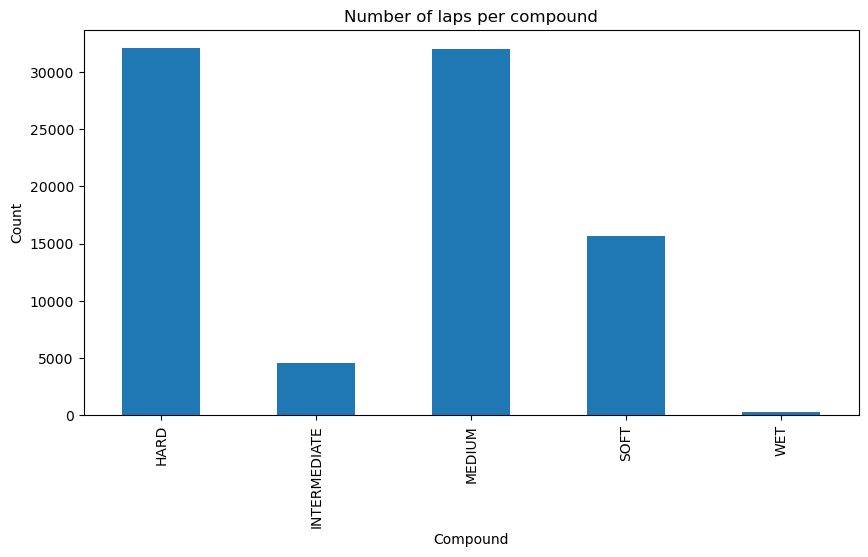

In [27]:
df.groupby('Compound').size().plot(
    kind='bar', 
    figsize=(10, 5),
    title='Number of laps per compound',
    xlabel='Compound',
    ylabel='Count',
    )

### Analyse de forme

* Variable target : is_pitting
* Lignes et colonnes : 84'630 lignes, 22 colonnes
* Types de variables :
  * quantitative : 11
  * qualitative : 11
* Valeurs manquantes : Très peu, environ 1600 lignes soit ~2% du dataset => suprimées

In [28]:
df.shape

(84630, 22)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84630 entries, 20 to 87844
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   LapNumber                84630 non-null  uint8   
 1   LapTime                  84630 non-null  float32 
 2   Compound                 84630 non-null  category
 3   TyreLife                 84630 non-null  uint8   
 4   Stint                    84630 non-null  uint8   
 5   DistanceToDriverAhead    80084 non-null  float32 
 6   PitStatus                84630 non-null  category
 7   IsAccurate               84630 non-null  bool    
 8   NumberOfPitStops         84630 non-null  uint8   
 9   Position                 84630 non-null  uint8   
 10  GapToLeader              71034 non-null  float32 
 11  IntervalToPositionAhead  84465 non-null  float32 
 12  LapsToLeader             84630 non-null  uint8   
 13  Track                    84630 non-null  category
 14  Total

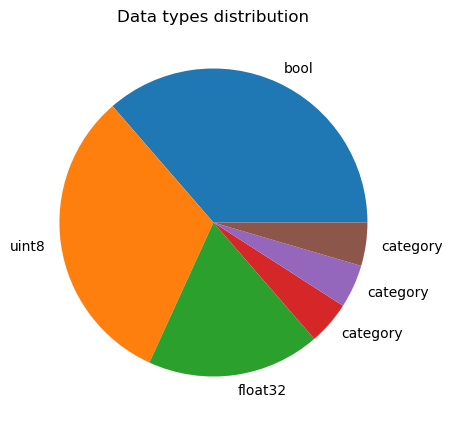

In [30]:
plt.figure(figsize=(10, 5))

df.dtypes.value_counts().plot.pie(
    figsize=(5, 5),
    title='Data types distribution',
)

plt.savefig(format='svg', fname='figures/data_types_distribution.svg')

### Analyse de Fond

* Visualisation de la target : Très déséquilibré (3% de cas positifs)
* Signification des variables : Je vais regrouper les variables en catégories
  * Variables de situation :
    * LapNumber
    * LapTime
    * Position
    * GapToLeader
    * IntervalToPositionAhead
    * DistanceToDriverAhead
    * LapsToLeader
  * Variables des pneumatiques :
    * Compound
    * TyreLife
    * Stint
    * PitStatus
    * NumberPitStops
  * Variables d'état de la course :
    * Green
    * Yellow
    * SC
    * Red
    * VSC
    * SC_ending
    * IsAccurate
  * Variables de session :
    * Track
    * TotalLaps
* Relation Variables / Target :

In [31]:
situation_vars = ['LapNumber', 'LapTime', 'Position', 'GapToLeader', 'IntervalToPositionAhead', 'DistanceToDriverAhead', 'LapsToLeader']
tyre_vars = ['Compound', 'TyreLife', 'Stint', 'PitStatus', 'NumberOfPitStops']
flags_vars = ['Green', 'Yellow', 'SC', 'Red', 'VSC', 'SC_ending']
session_vars = ['Track', 'TotalLaps']

##### Target

In [32]:
def plot_binary(df, col):
    plt.figure(figsize=(5, 5))
    plt.pie(df[col].value_counts(), labels=df[col].value_counts().index, autopct='%1.1f%%')
    plt.title(f'Distribution of {col}')
    plt.savefig(format='svg', fname=f'figures/{col}_distribution.svg')
    plt.show()

In [33]:
df['is_pitting'].value_counts(normalize=True)

False    0.970318
True     0.029682
Name: is_pitting, dtype: float64

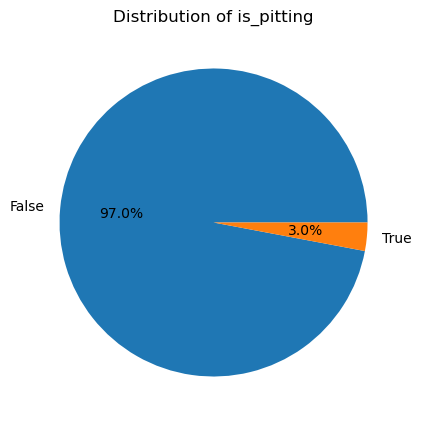

In [34]:
plot_binary(df, 'is_pitting')

#### Variables quantitatives

In [35]:
df2 = df.copy()

In [36]:
from sklearn.preprocessing import StandardScaler
def scale(df, cols):
    scaler = StandardScaler()
    df[cols] = scaler.fit_transform(df[cols])
    return df

columns_to_scale = df2.select_dtypes(include='number').columns
df2 = scale(df2, columns_to_scale)
df2.head()

,LapNumber,LapTime,Compound,TyreLife,Stint,DistanceToDriverAhead,PitStatus,IsAccurate,NumberOfPitStops,Position,...,LapsToLeader,Track,TotalLaps,Green,Yellow,SC,Red,VSC,SC_ending,is_pitting
20,-1.610205,-0.094606,SOFT,-1.009187,-1.106827,NaN,NoPit,True,-1.081225,-1.618397,...,-0.413376,Melbourne,-0.428142,True,False,False,False,False,False,False
21,-1.610205,-0.088014,SOFT,-1.009187,-1.106827,-0.176248,NoPit,True,-1.081225,-1.433744,...,-0.413376,Melbourne,-0.428142,True,False,False,False,False,False,False
22,-1.610205,-0.065180,SOFT,-1.009187,-1.106827,-0.224087,NoPit,True,-1.081225,-1.249091,...,-0.413376,Melbourne,-0.428142,True,False,False,False,False,False,False
23,-1.610205,-0.068034,SOFT,-1.009187,-1.106827,-0.209313,NoPit,True,-1.081225,-1.064438,...,-0.413376,Melbourne,-0.428142,True,False,False,False,False,False,False
24,-1.610205,-0.028414,SOFT,-1.009187,-1.106827,-0.206434,NoPit,True,-1.081225,-0.879786,...,-0.413376,Melbourne,-0.428142,True,False,False,False,False,False,False


In [37]:
def draw_distribution(df, column, bins=50):
    plt.figure(figsize=(10, 5))
    sns.distplot(df[column], bins=bins)
    plt.title(f'Distribution of {column}')
    plt.savefig(format='svg', fname=f'figures/{column}_distribution.svg')
    plt.show()

##### LapNumber

La variable ``LapNumber`` représente le numéro du tour. On remarque que la distribution est très uniforme, ce qui est logique car la variable augmente linéairement au fil de la course. On remarque par contre qu'elle est asymétrique, ce qui est logique car certaines voitures ne terminent pas la course et certaines courses sont plus longues que d'autres.

C:\Users\NelsonWork\AppData\Local\Temp\ipykernel_9180\2774783341.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], bins=bins)


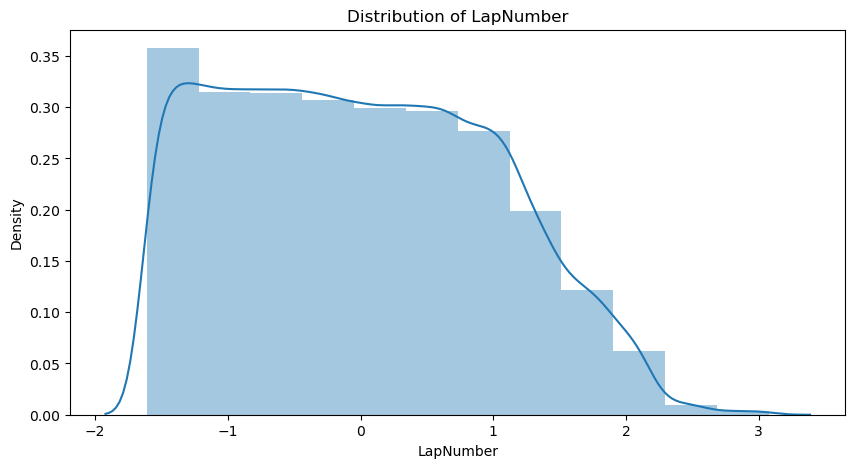

In [38]:
draw_distribution(df2, 'LapNumber', bins=12)

##### LapTime

La variable ``LapTime`` représente le temps du tour en secondes. On remarque que la distribution est presque normale et symétrique.

C:\Users\NelsonWork\AppData\Local\Temp\ipykernel_9180\2774783341.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], bins=bins)


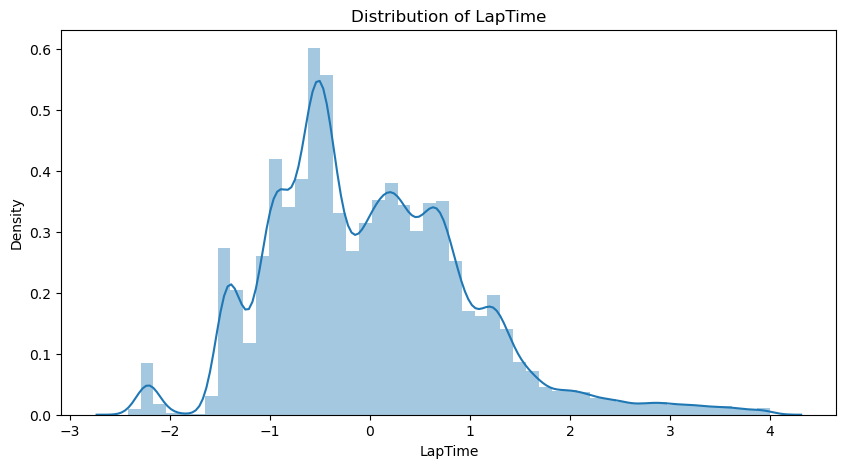

In [39]:
draw_distribution(df2, 'LapTime')

##### TyreLife

La distribution est unimodal et asymetrique, cela est dû à la nature de l'évolution de l'age des pneumatiques lors de la course. Sur une course de 60 tours, une voiture qui s'arrête tout les 20 tours aura 3 tours avec `TyreLife=[1..20]`. Comparé à une voiture qui fait aucun arrêt.

C:\Users\NelsonWork\AppData\Local\Temp\ipykernel_9180\2774783341.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], bins=bins)


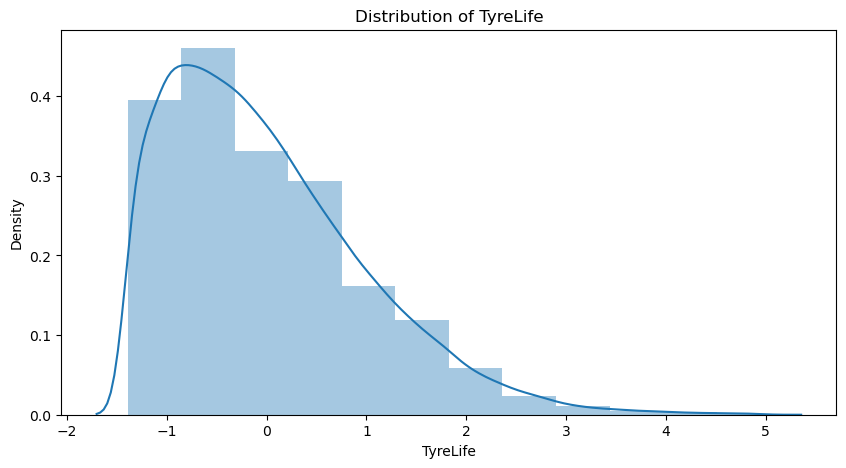

In [40]:
draw_distribution(df2, 'TyreLife', bins=12)

##### Stint

La distribution est très similaire à celle de `TyreLife` ce qui est logique car `Stint` représente le "relais" d'une voiture (commence à 1 et augmente à chaque arrêt).

C:\Users\NelsonWork\AppData\Local\Temp\ipykernel_9180\2774783341.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], bins=bins)


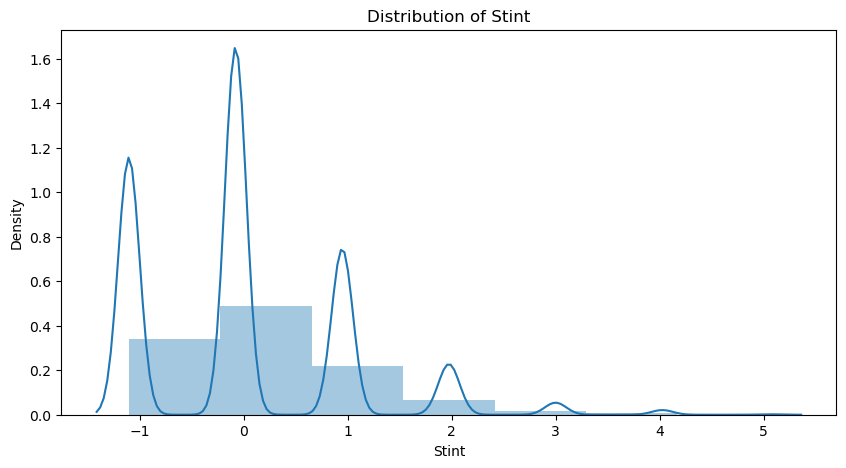

In [41]:
draw_distribution(df2, 'Stint', bins=7)

##### NumberOfPitStops

Cette variable est très similaire à `Stint` ce qui est logique car `NumberOfPitStops` représente le nombre d'arrêt au stand de la voiture. Il faudrait donc supprimer une des 2 variables pour éviter la redondance.

C:\Users\NelsonWork\AppData\Local\Temp\ipykernel_9180\2774783341.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], bins=bins)


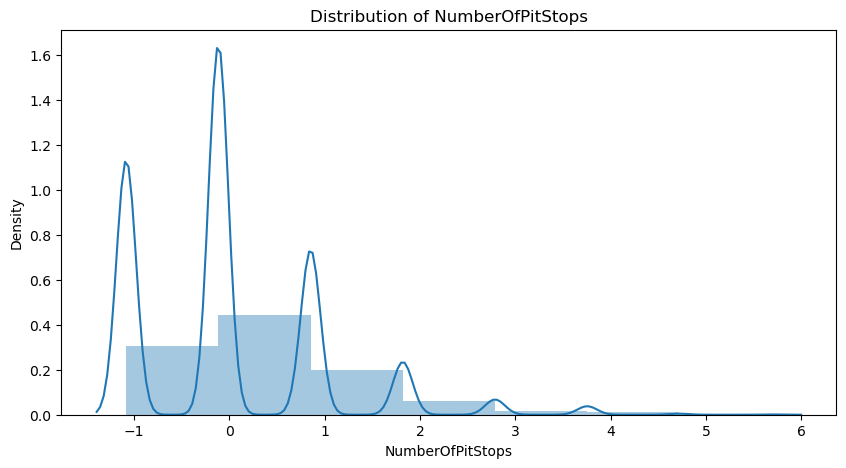

In [42]:
draw_distribution(df2, 'NumberOfPitStops', bins=7)

##### Position

La distribution de `Position` est uniforme avec une asymétrie à droite, à cause des voitures qui ne terminent pas la course.

C:\Users\NelsonWork\AppData\Local\Temp\ipykernel_9180\2774783341.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], bins=bins)


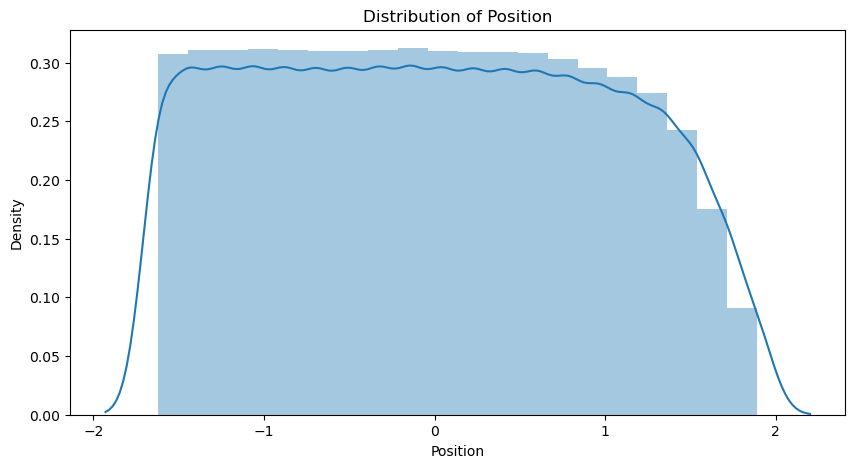

In [43]:
draw_distribution(df2, 'Position', bins=20)

##### GapToLeader

La distribution est très concentrée autour de 0 étant donnée que le leader de la course est toujours à 0. La distribution est très asymétrique à droite, ce qui est logique car la plupart des pilotes sont assez près du leader au début de la course. On peut noter également qu'un nombre important de valeurs NaN qui représente les pilotes à plus d'un tour du leader.

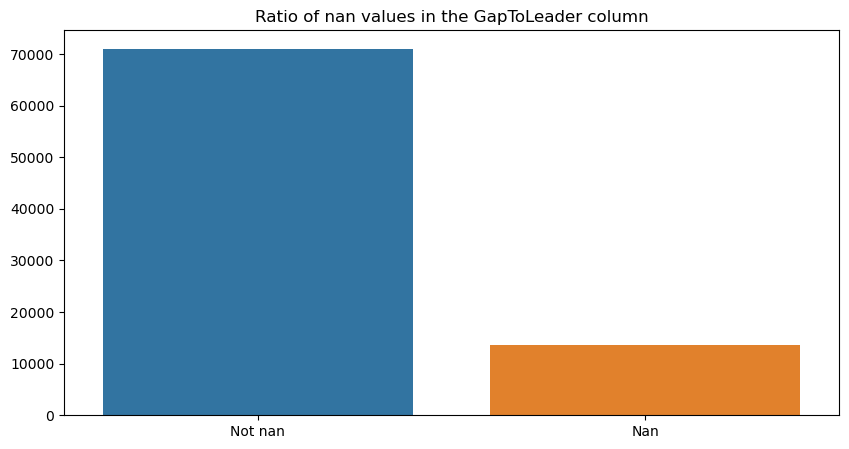

In [44]:
# draw the ratio of nan values in the GapToLeader column
plt.figure(figsize=(10, 5))
sns.barplot(x=df['GapToLeader'].isna().value_counts().index, y=df['GapToLeader'].isna().value_counts().values)
plt.title('Ratio of nan values in the GapToLeader column')
plt.xticks([0, 1], ['Not nan', 'Nan'])
plt.show()

C:\Users\NelsonWork\AppData\Local\Temp\ipykernel_9180\2774783341.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], bins=bins)


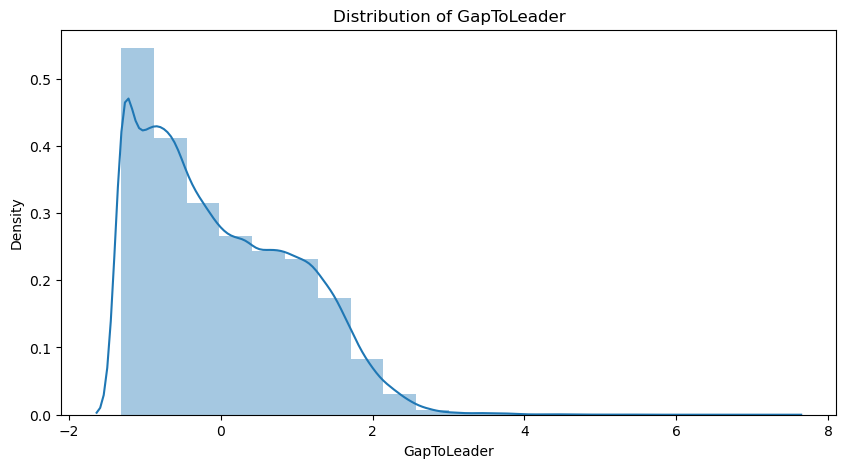

In [45]:
draw_distribution(df2, 'GapToLeader', bins=20)

##### DistanceToDriverAhead

La distribution est très "piquée" avec énormément de valeurs entre 0 et 1 et le reste dispercée entre 10 et 100

p:\Anaconda\envs\bsc\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


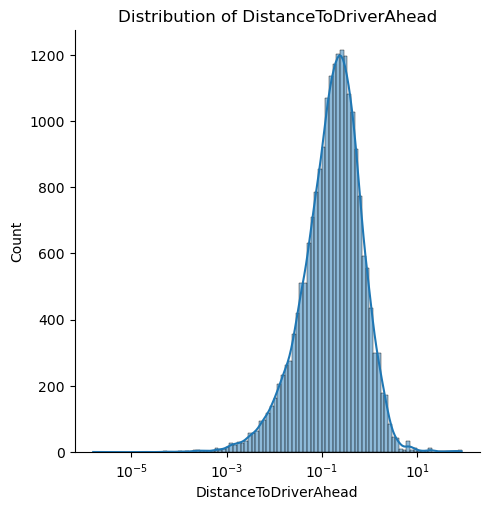

In [46]:
sns.displot(df2['DistanceToDriverAhead'], kde=True, bins=100, log_scale=True)
plt.title('Distribution of DistanceToDriverAhead')
plt.savefig(format='svg', fname='figures/DistanceToDriverAhead_distribution.svg')
plt.show()

##### IntervalToPositionAhead

Étant donnée que cette variable est "soeur" de `DistanceToDriverAhead` (L'une représente la distance en mètre et l'autre en secondes), on peut s'attendre à une distribution similaire. Il faudrait vérifier si l'une des 2 variables est redondante.

p:\Anaconda\envs\bsc\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


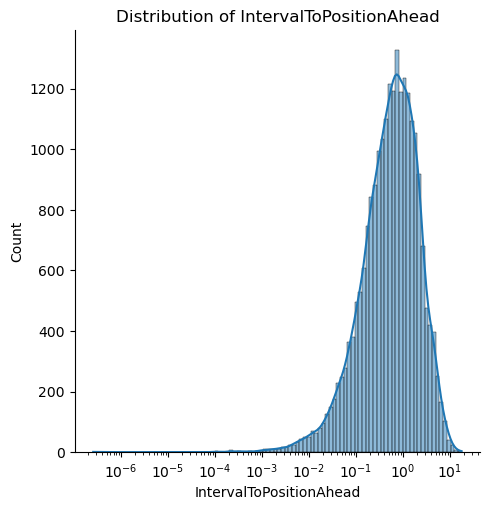

In [47]:
sns.displot(df2['IntervalToPositionAhead'], kde=True, bins=100, log_scale=True)
plt.title('Distribution of IntervalToPositionAhead')
plt.show()

##### LapsToLeader

La distribution est asymetrique à droite avec une concentration autour de 0. Cela est logique car la plupart des pilotes sont dans le même tour que le leader.

C:\Users\NelsonWork\AppData\Local\Temp\ipykernel_9180\2774783341.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], bins=bins)


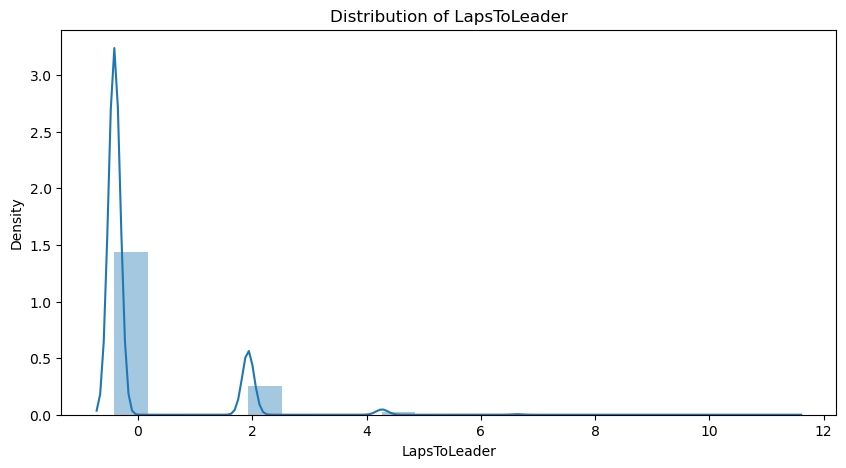

In [48]:
draw_distribution(df2, 'LapsToLeader', bins=20)

##### TotalLaps

La varaible `TotalLaps` représente le nombre de tours de la course. On remarque que la distribution est multimodals, cela est du au fait que les circuits ont chaque année le même nombre de tours et qu'il y a un nombre assez faible de circuits différents.

C:\Users\NelsonWork\AppData\Local\Temp\ipykernel_9180\2774783341.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], bins=bins)


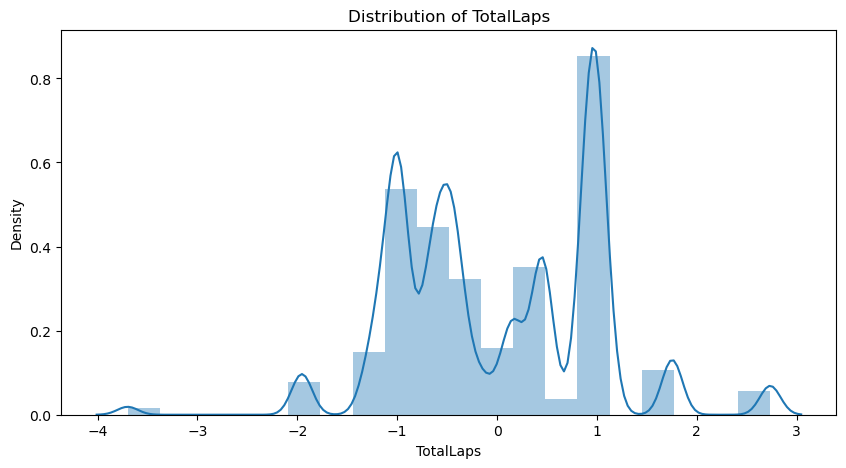

In [49]:
draw_distribution(df2, 'TotalLaps', bins=20)

#### Variables qualitatives

In [50]:
def plot_categorical(df, col):
    sns.displot(df[col], height=5, aspect=2)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=90)
    plt.savefig(format='svg', fname=f'figures/{col}_distribution.svg')
    plt.show()

##### Compound

La variable `Compound` représente le type de pneumatique utilisé par la voiture. On remarque que les pneumatiques les plus utilisés sont les pneumatiques durs et mediums. Les pneumatiques tendres sont utilisés beaucoup moins souvent, ce qui est logique car ils sont moins durables.

Les intermédiaires et les wets sont utilisés beaucoup moins souvent car ils ne sont utilisés que dans des conditions météorologiques particulières.

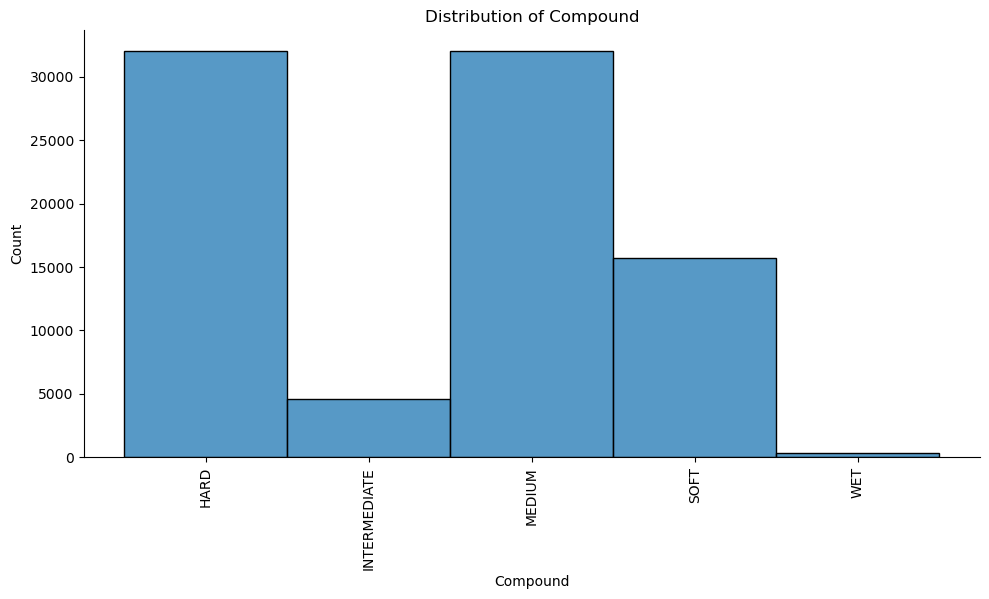

In [51]:
plot_categorical(df, 'Compound')

##### PitStatus

`PitStatus` représente l'état de la voiture par rapport à l'arrêt au stand. Elle peut prendre 3 valeurs : `InLap`, `NoPit` et `OutLap`. Respectivement : la voiture est en train d'entrer au stand, la voiture n'est pas en train d'entrer au stand et la voiture est en train de sortir du stand.

La distribution est très déséquilibrée, cela est du au fait que les voitures ne rentrent au stand que 1 à 3 fois par course. Cependant elle est symétrique étant donnée que pour sortir du stand, la voiture doit d'abord entrer au stand.

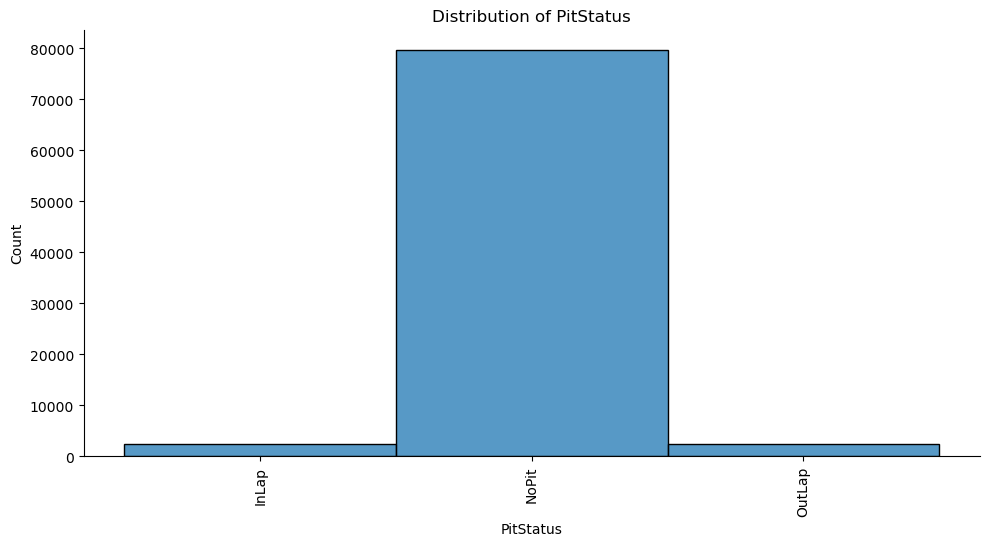

In [52]:
plot_categorical(df, 'PitStatus')

##### Track

`Track` représente le circuit sur lequel la course a lieu. On remarque que la distribution est assez déséquilibrée, notament car certains circuits sont plus courts que d'autres se qu'il fait que les pilotes effectuent moins de tours sur ces circuits. Et d'autre ne sont pas utilisés tous les ans comme le Mugello qui a été utilisé que une fois en 2020

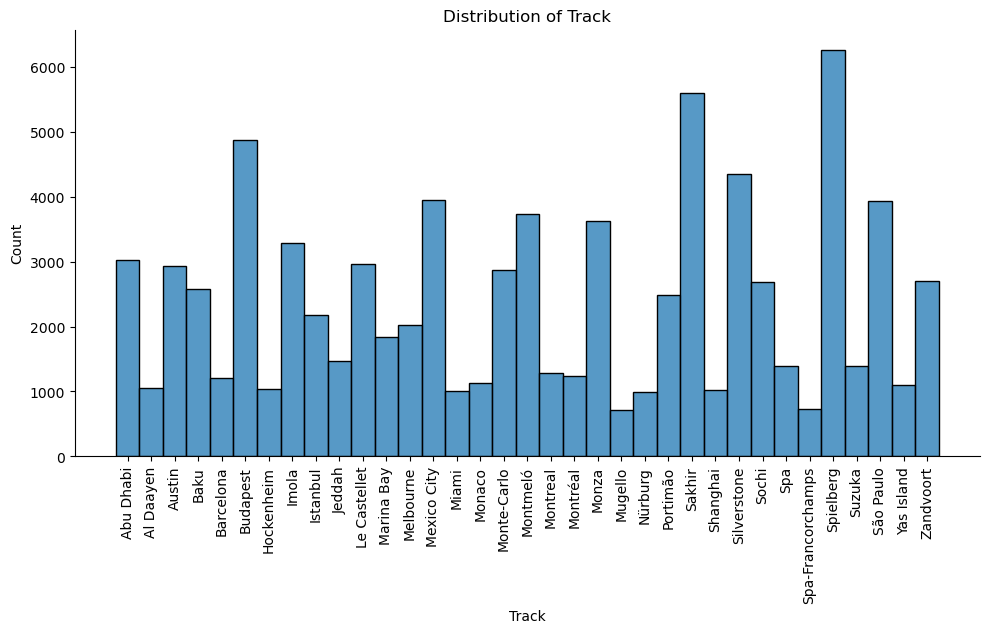

In [53]:
plot_categorical(df, 'Track')

##### IsAccurate

D'après la documentation FastF1 : 
> Laps need to satisfy the following criteria to be marked as accurate: 
> * not an inlap or outlap
> * set under green or yellow flag (the api sometimes has issues with data from SC/VSC laps)
> * is not the first lap after a safety car period (issues with SC/VSC might still appear on the first lap after it has ended)
> * has a value for lap time and all sector times

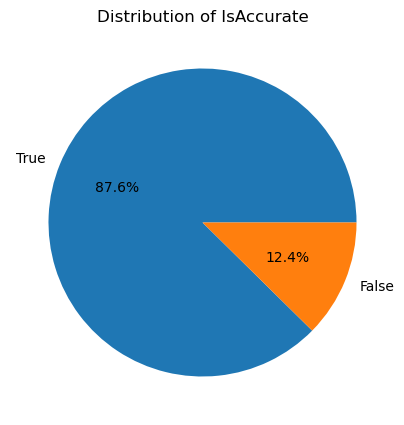

In [54]:
plot_binary(df, 'IsAccurate')

##### Green, Yellow, SC, Red, VSC, SC_ending

`Green`, `Yellow`, `SC`, `Red`, `VSC`, `SC_ending` sont des variables binaires qui représentent les différents états de la course. On remarque que la distribution est très déséquilibrée, cela est du au fait que la plupart du temps la course se déroule sous drapeau vert.

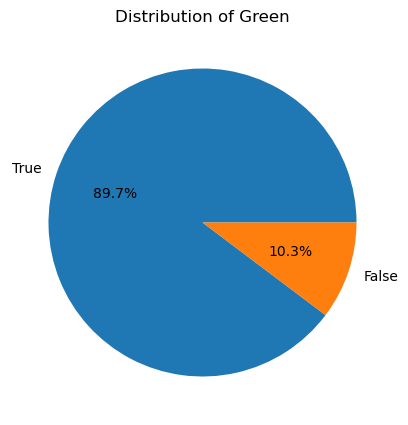

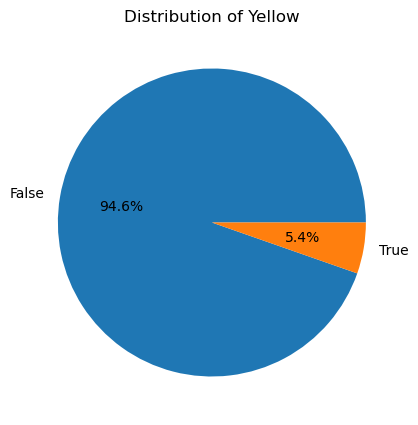

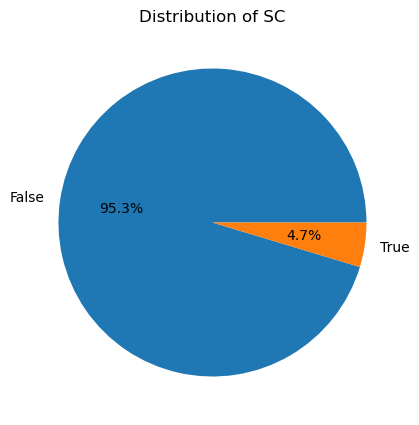

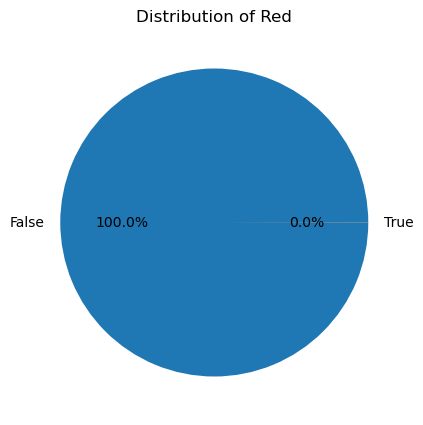

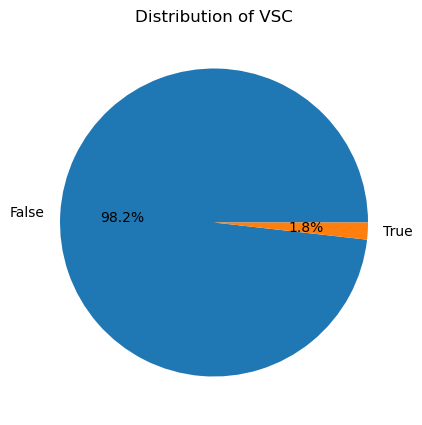

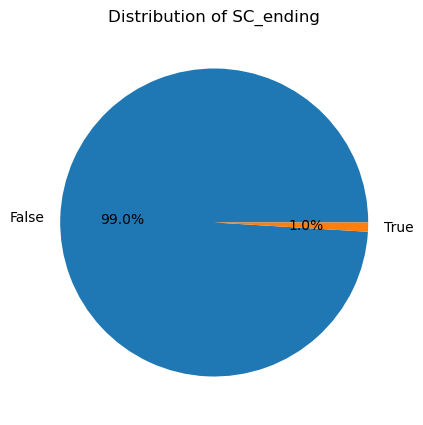

In [55]:
for col in ['Green', 'Yellow', 'SC', 'Red', 'VSC', 'SC_ending']:
    plot_binary(df, col)

#### Relation Target / Variables

In [56]:
pitting_df = df[df['is_pitting'] == True]
not_pitting_df = df[df['is_pitting'] == False]

In [57]:
def plot_relation_distribution(col):
    plt.figure(figsize=(10, 5))
    if pitting_df[col].dtype == 'category' :
        sns.countplot(x=col, data=df, hue='is_pitting')
        plt.legend()
    elif pitting_df[col].dtype == 'bool' :
        crs = pd.crosstab(df[col], df['is_pitting'])
        crs.loc[True, :] = crs.loc[True, :] / df[df[col] == True].shape[0]
        crs.loc[False, :] = crs.loc[False, :] / df[df[col] == False].shape[0]
        ax = sns.heatmap(crs, annot=True, fmt='.2%')
        cbar = ax.collections[0].colorbar
        cbar.set_ticks([0, .2, .75, 1])
        cbar.set_ticklabels(['low', '20%', '75%', '100%'])
    else :
        sns.kdeplot(pitting_df[col], label='Pitting')
        sns.kdeplot(not_pitting_df[col], label='Not pitting')
        plt.legend()
    plt.title(f'Distribution of {col}')
    plt.savefig(format='svg', fname=f'figures/{col}_distribution2.svg')
    plt.show()

##### Variables situation

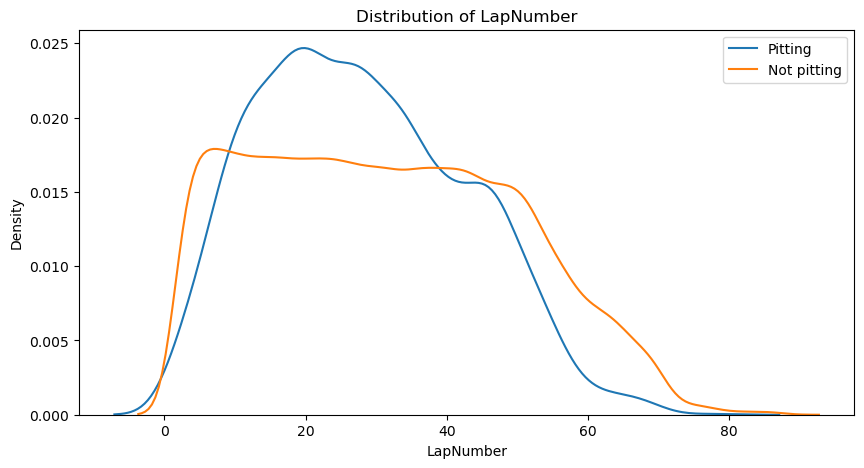

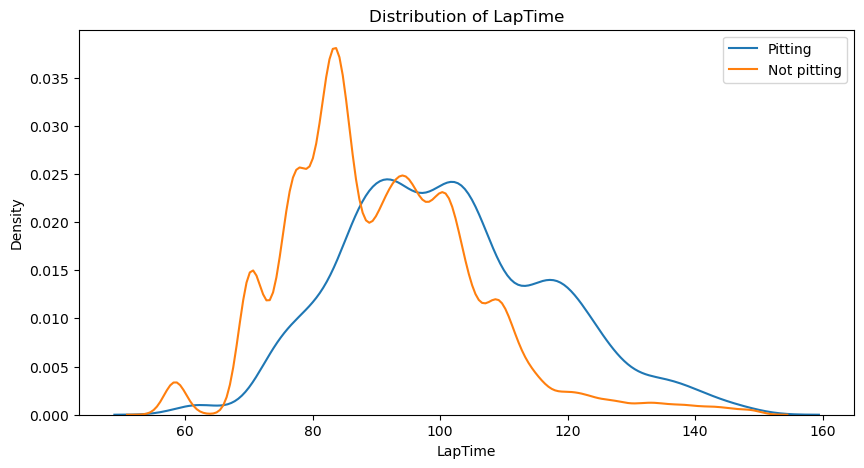

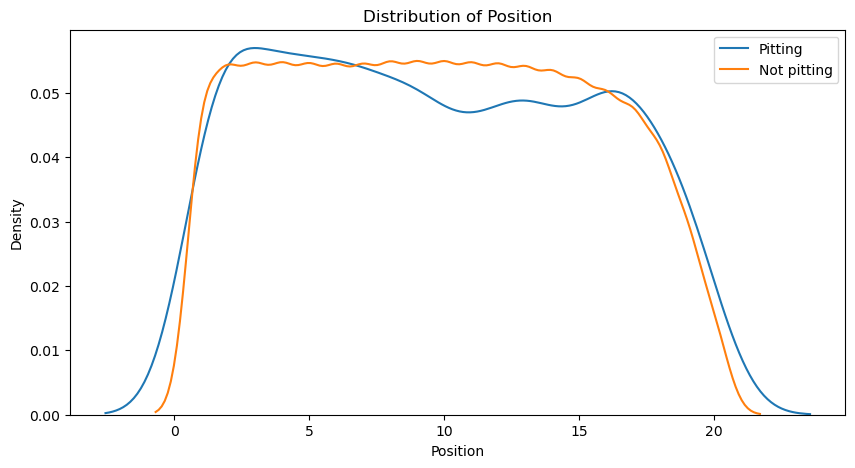

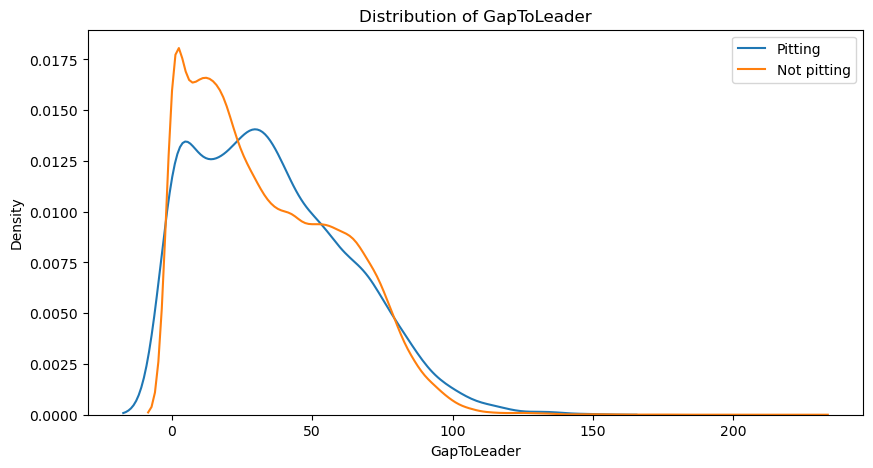

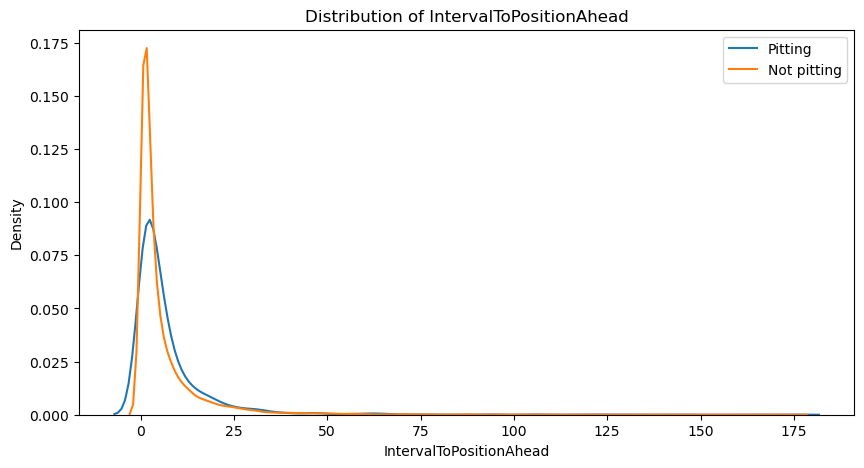

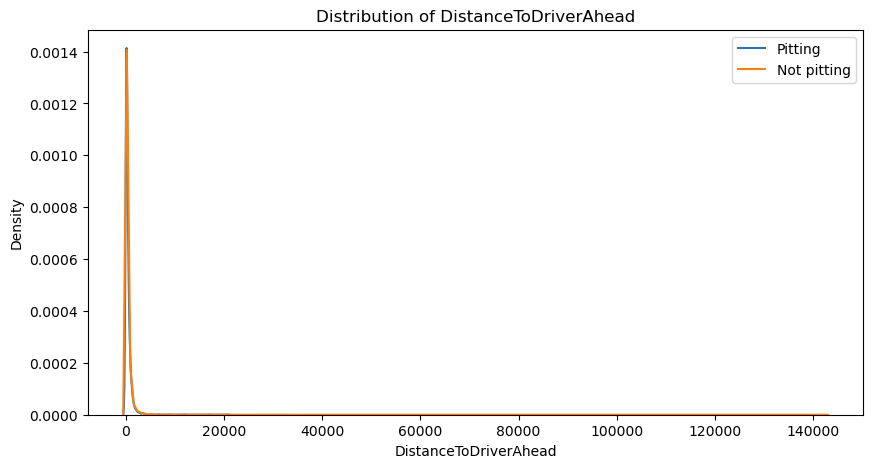

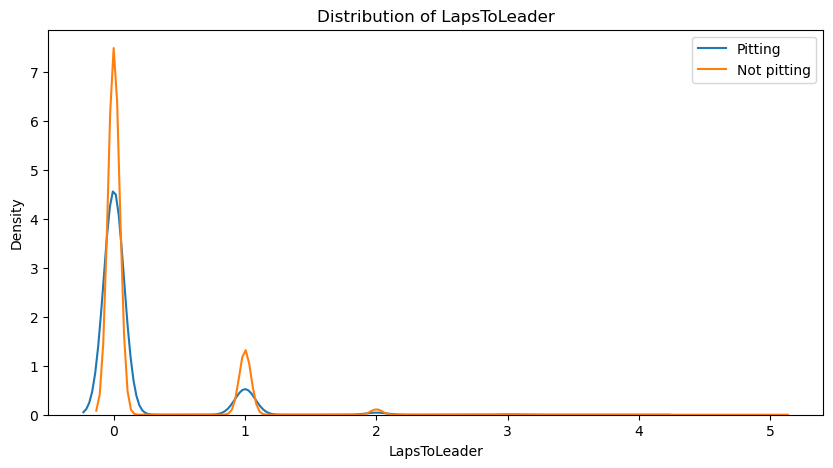

In [58]:
for col in situation_vars:
    plot_relation_distribution(col)

##### Variables pneumatiques

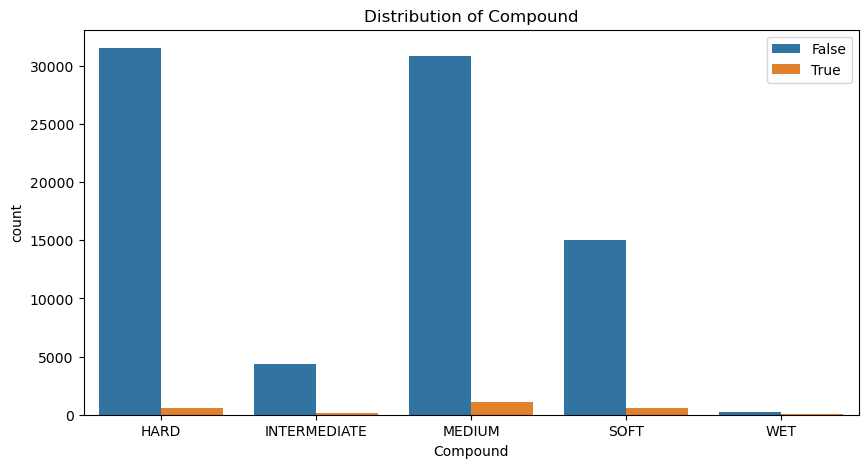

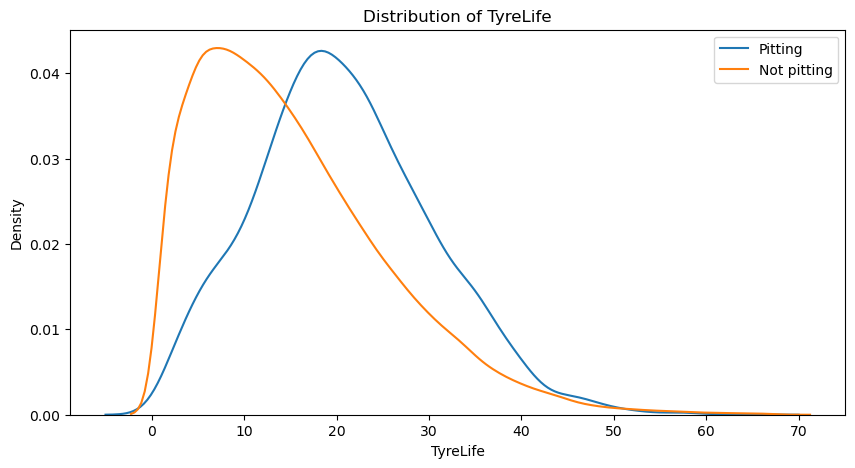

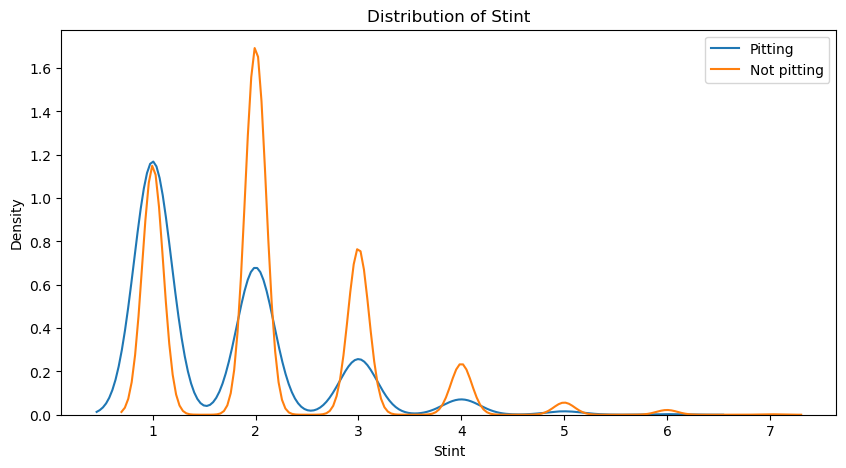

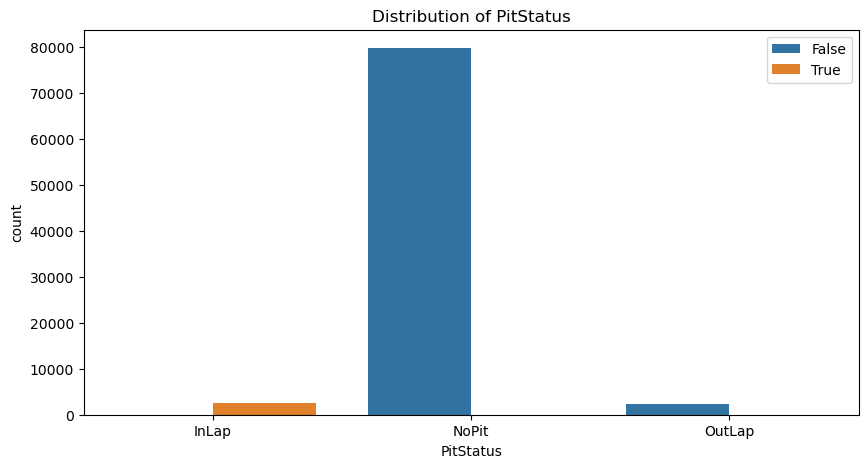

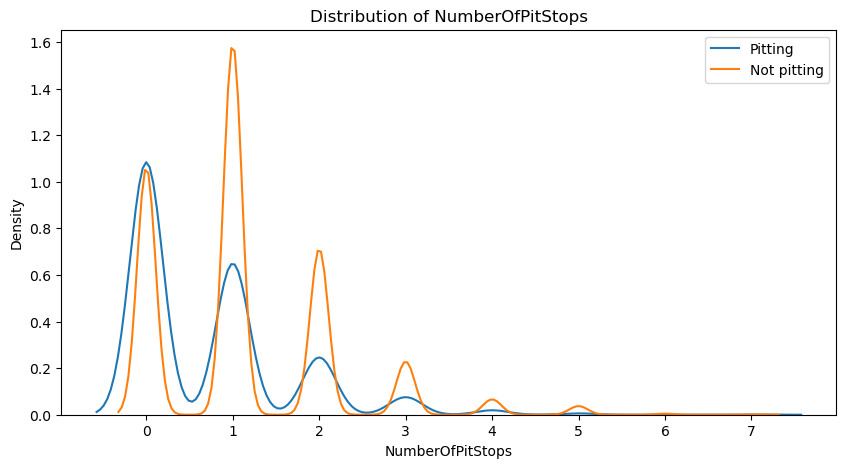

In [59]:
for col in tyre_vars:
    plot_relation_distribution(col)

##### Variables état de la course

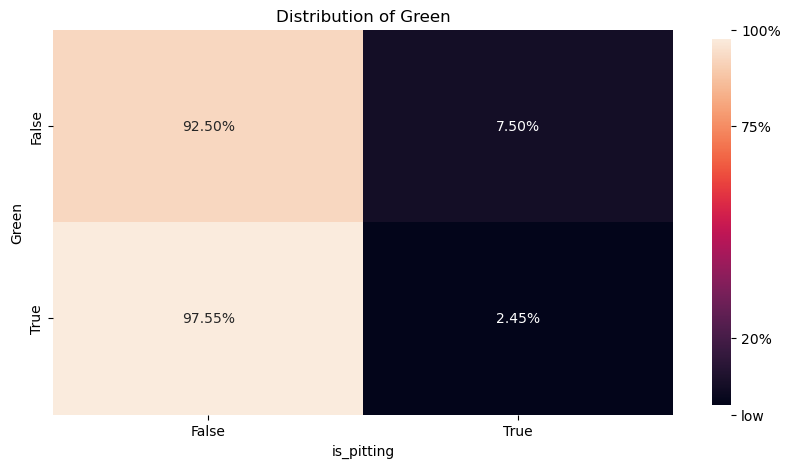

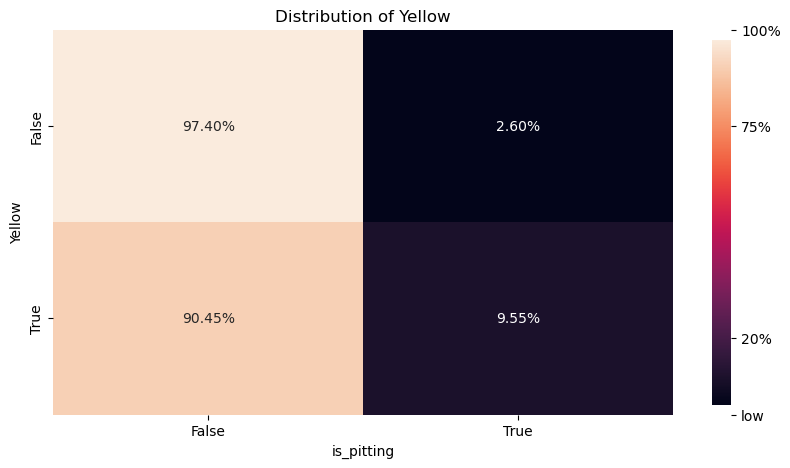

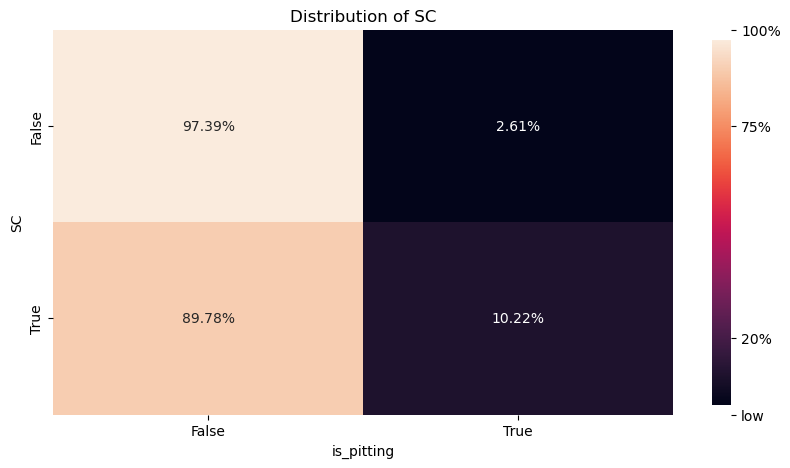

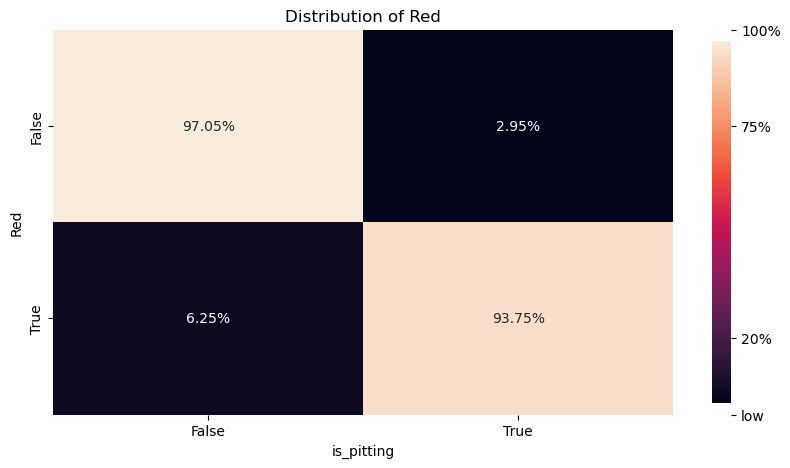

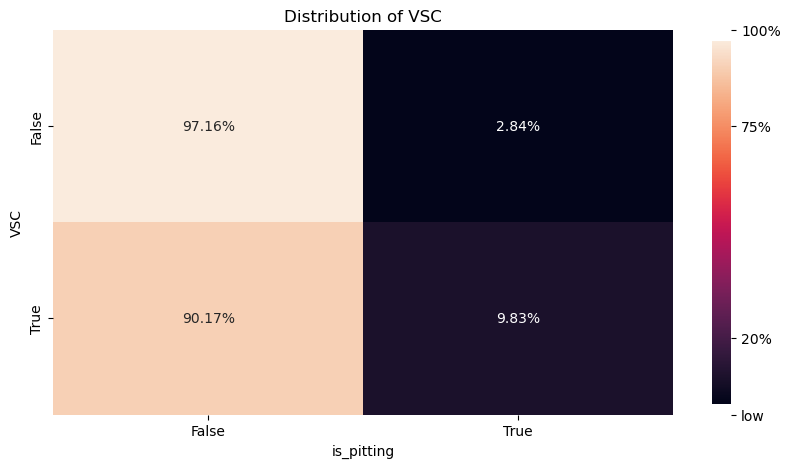

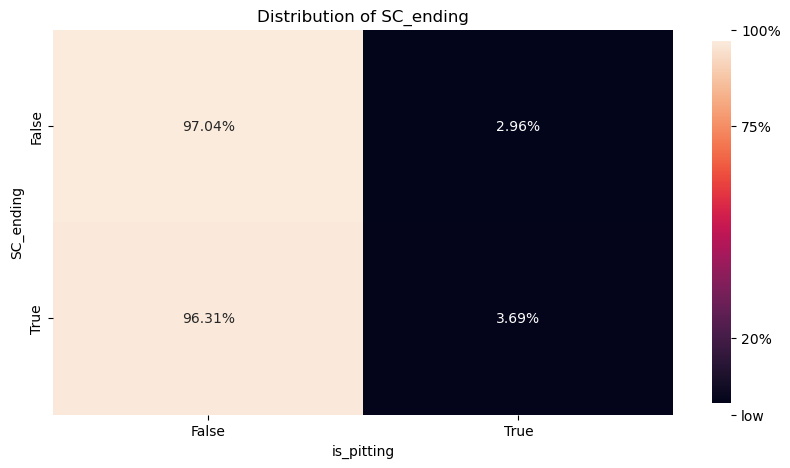

In [60]:
for col in flags_vars:
    plot_relation_distribution(col)

##### Variables de session

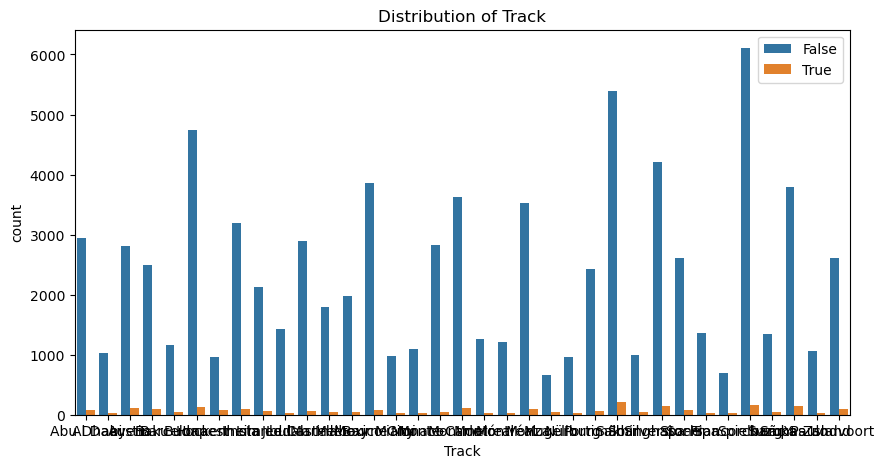

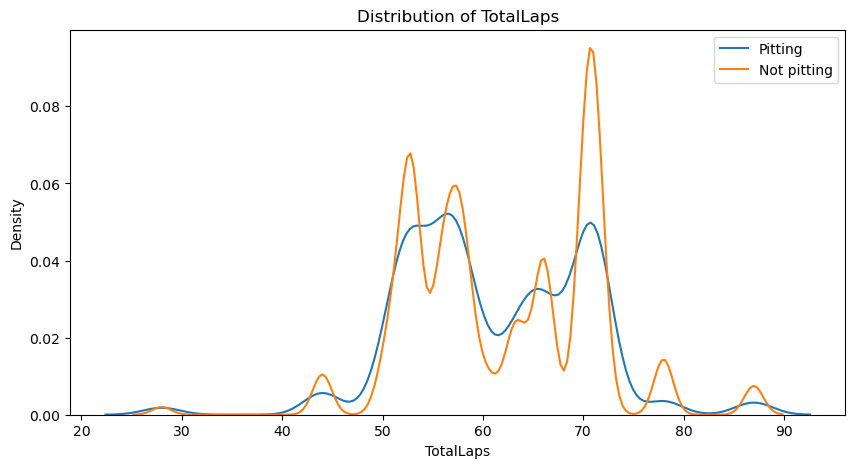

In [61]:
for col in session_vars:
    plot_relation_distribution(col)

### Correlation entre les features et la target avec différentes méthodes

In [62]:
def plot_corr(df):
    numerical_data = df.select_dtypes(include=['number', 'bool'])

    fig, ax = plt.subplots(3,1, figsize=(12, 12))
    ## Correlation coefficient using different methods
    corr1 = numerical_data.corr('pearson')[['is_pitting']].sort_values(by='is_pitting', ascending=False)
    corr2 = numerical_data.corr('spearman')[['is_pitting']].sort_values(by='is_pitting', ascending=False)
    corr3 = numerical_data.corr('kendall')[['is_pitting']].sort_values(by='is_pitting', ascending=False)

    #setting titles for each plot
    ax[0].set_title('Pearson method')
    ax[1].set_title('spearman method')
    ax[2].set_title('Kendall method')
    ## Generating heatmaps of each methods
    sns.heatmap(corr1, ax=ax[0], annot=True)
    sns.heatmap(corr2, ax=ax[1], annot=True)
    sns.heatmap(corr3, ax=ax[2], annot=True)

    plt.show()

### Analyse détaillée
Relation Variables / Variables :

#### Variables de situation

In [63]:
#sns.pairplot(df2, hue='is_pitting', vars=situation_vars)

In [64]:
#sns.clustermap(df2.corr(), annot=True, fmt='.2f')

### Hypothèses

1. Normaliser le nombre de tours en fonction du nombre de tours de la course, pour créer une variable pourcentage de la course effectuée, permet de comparer le nombre de tours de différentes courses et améliorer le pouvoir prédictif de la variable `LapNumber`.

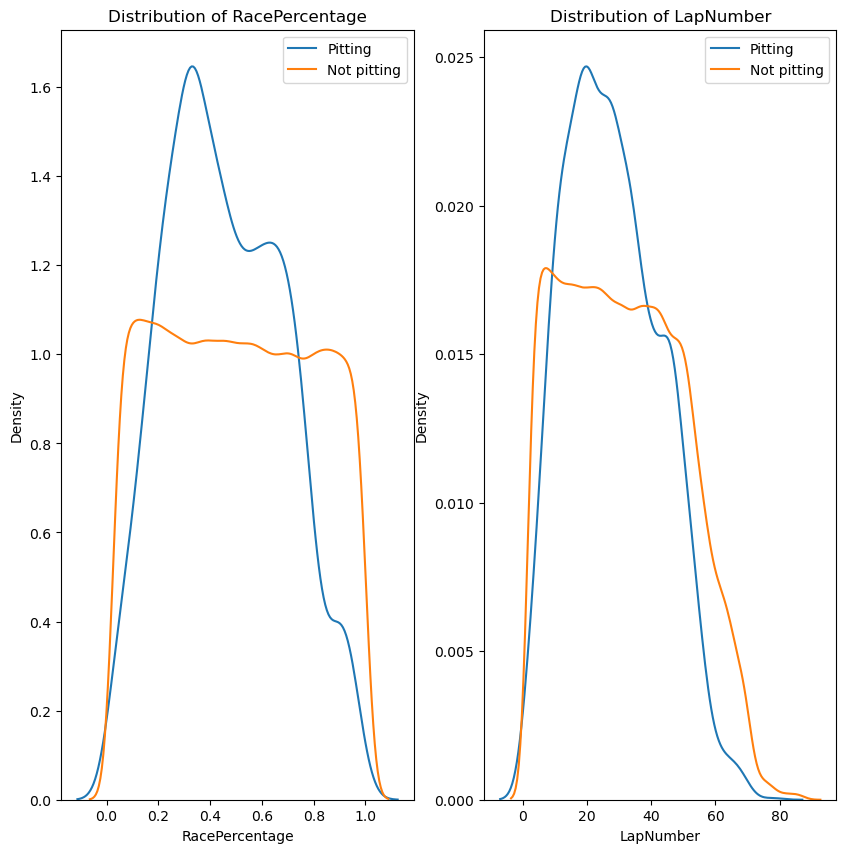

In [65]:
df['RacePercentage'] = df['LapNumber'] / df['TotalLaps']

pitting_df = df[df['is_pitting'] == True]
not_pitting_df = df[df['is_pitting'] == False]

plt.subplots(figsize=(10, 10), ncols=2, nrows=1, sharey=False)
plt.subplot(1, 2, 1)
sns.kdeplot(pitting_df['RacePercentage'], label='Pitting')
sns.kdeplot(not_pitting_df['RacePercentage'], label='Not pitting')
plt.legend()
plt.title('Distribution of RacePercentage')
plt.subplot(1, 2, 2)
sns.kdeplot(pitting_df['LapNumber'], label='Pitting')
sns.kdeplot(not_pitting_df['LapNumber'], label='Not pitting')
plt.legend()
plt.title('Distribution of LapNumber')
plt.show()


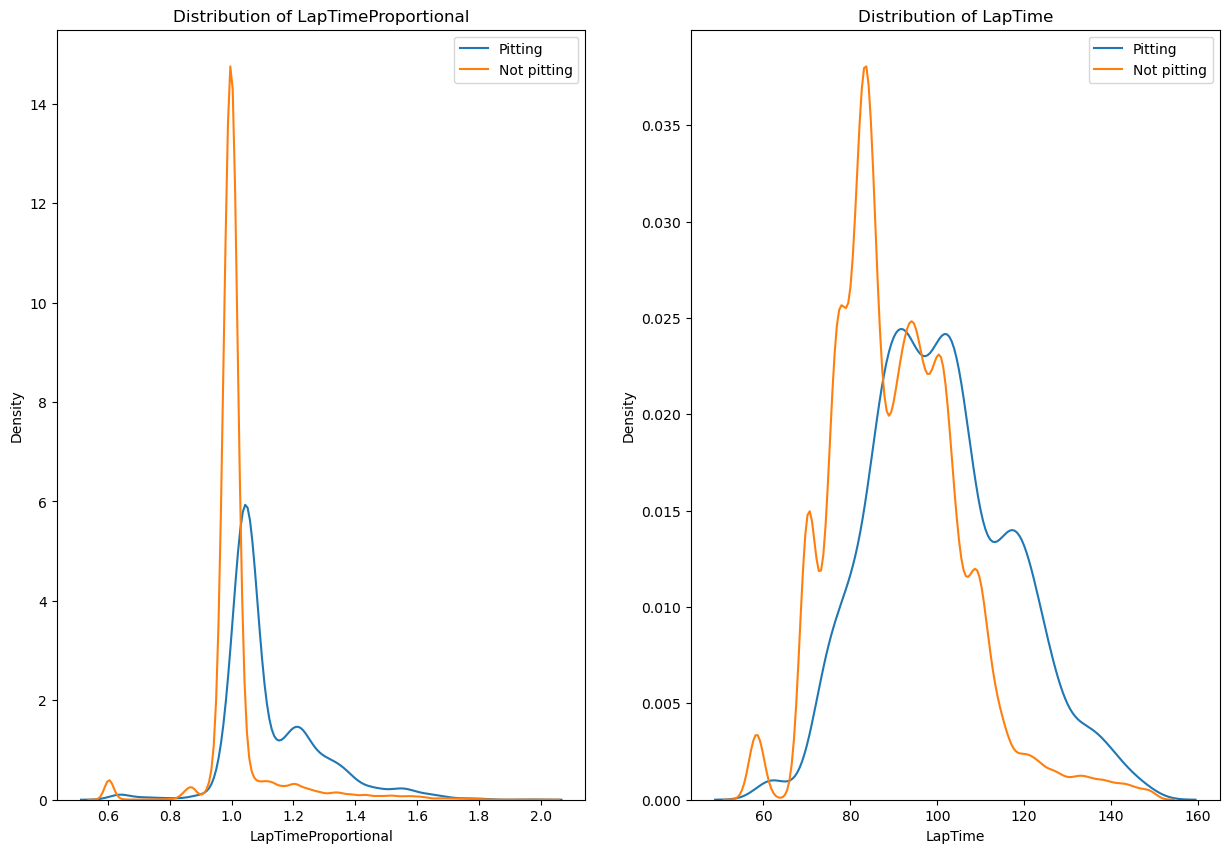

In [66]:
df['LapTimeProportional'] = df['LapTime'] / df.groupby('Track')['LapTime'].transform('median')

pitting_df = df[df['is_pitting'] == True]
not_pitting_df = df[df['is_pitting'] == False]

plt.subplots(figsize=(15, 10), ncols=2, nrows=1, sharey=False)
plt.subplot(1, 2, 1)
sns.kdeplot(pitting_df['LapTimeProportional'], label='Pitting')
sns.kdeplot(not_pitting_df['LapTimeProportional'], label='Not pitting')
plt.legend()
plt.title('Distribution of LapTimeProportional')
plt.subplot(1, 2, 2)
sns.kdeplot(pitting_df['LapTime'], label='Pitting')
sns.kdeplot(not_pitting_df['LapTime'], label='Not pitting')
plt.legend()
plt.title('Distribution of LapTime')
plt.show()


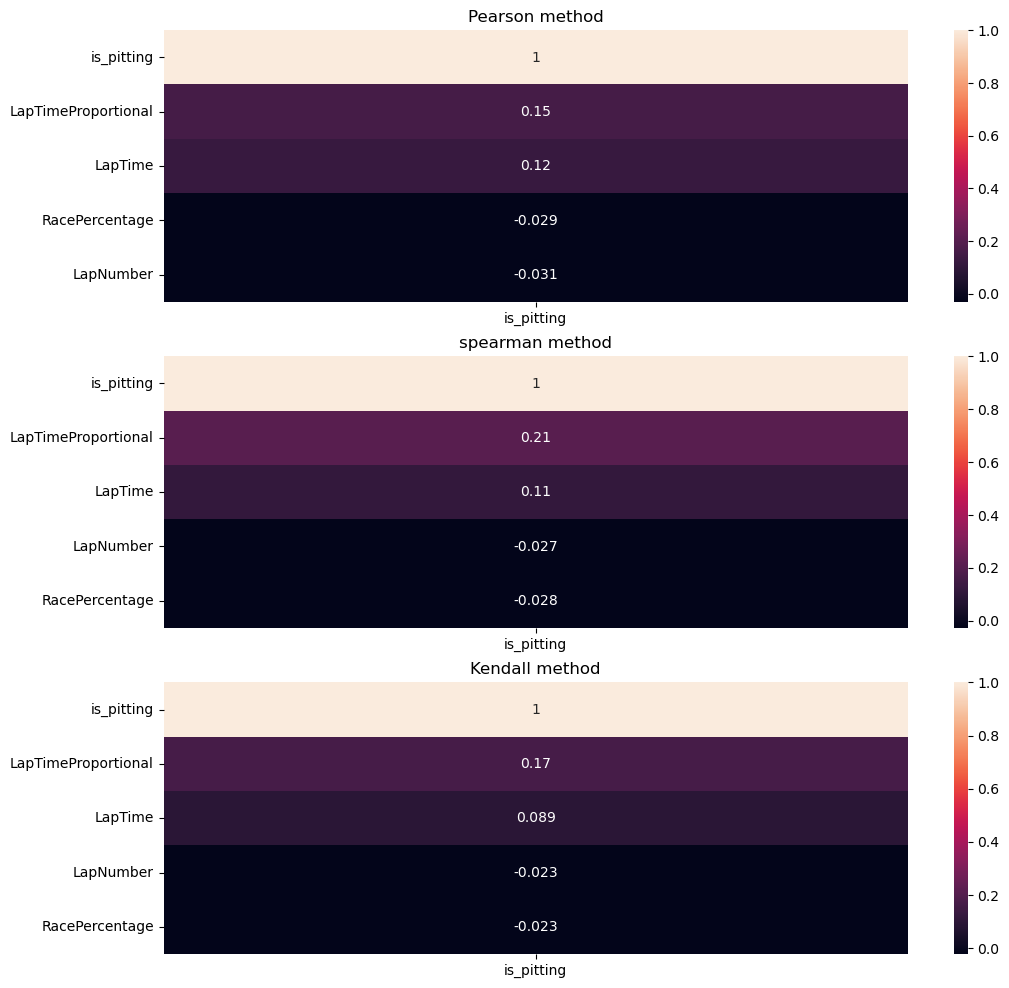

In [67]:
#plot_corr(df.drop(columns=['IsAccurate']))
plot_corr(df[['LapNumber', 'RacePercentage', 'LapTimeProportional','LapTime', 'is_pitting']])

In [68]:
from scipy.stats import ttest_ind
def t_test(col):
    print(f'T-test for {col}')
    print(ttest_ind(pitting_df[col], not_pitting_df[col]))
    print()

t_test('RacePercentage')
t_test('LapNumber')

T-test for RacePercentage
Ttest_indResult(statistic=-8.413234829167584, pvalue=4.0496735076610345e-17)

T-test for LapNumber
Ttest_indResult(statistic=-9.058798155571923, pvalue=1.346090028740127e-19)



In [69]:
from scipy.stats import pearsonr
def pearson_corr(col):
    print(f'Pearson correlation for {col}')
    print(pearsonr(df[col], df['is_pitting']))
    print()

pearson_corr('RacePercentage')
pearson_corr('LapNumber')

Pearson correlation for RacePercentage
PearsonRResult(statistic=-0.02890842475236367, pvalue=4.049673507709406e-17)

Pearson correlation for LapNumber
PearsonRResult(statistic=-0.031124550182070464, pvalue=1.3460900287586417e-19)

